# DSxH 2324 Assignment 1: Prediction of Length Of Stay in ICU

## Introduction

We will work with the [**MIMIC-III Clinical Database Demo**](https://physionet.org/content/mimiciii-demo/1.4/) which contains all intensive care unit (ICU) stays for 100 patients (randomly selected from the subset of patients in the dataset who eventually die).
The main task is to predict the Length Of Stay (LOS) in the ICU using different strategies: (1) using the severity of illness score OASIS, and (2) using all the 
variables. 

#### OASIS

The Oxford Acute Severity of Illness Score (OASIS) is based on the following variables: age, elective surgery, prior length of stay (LOS) and seven physiologic measurements: Glasgow Coma Score (GCS), heart rate, mean arterial pressure (MAP), respiratory rate, temperature, urine output, ventilated. For each variable, the worst score across the first day in ICU should be used to tabulate OASIS.

See [here](https://alistairewj.github.io/project/oasis/) for more information.

**Observation**: The concept of *elective surgery* is where a patient is admitted to the intensive care unit either in routine preparation for a planned surgery or for stabilization after completion of a planned surgery. Elective surgery is an important covariate for many risk adjustments as patients who are admitted to the ICU for planned surgeries tend to be healthier than their counterparts.


## Exercise 1:

Predict if the length of stay (LOS) of the ICU patients are "short" or "long" (binary classification problem) based on the severity score OASIS of the fisrt 24 hours (and 48 hours) of an ICU stay.


### Instructions for the exercise 1

- We provide you the variables already computed and saved in csv files, except age, elective surgery, pre-LOS and temperature.

- In order to compute the age and pre-LOS and consult the elective surgery information you need to  tables PATIENTS, ADMISSIONS and ICUSTAYS. 
    - You should compute the age at the time the patient is admitted to the ICU from *date of birth*, 'dob' from PATIENTS table, then you can drop dob from the dataframe. 
    - For the pre-LOS you should compare 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table. 
    - The elective surgery information is stored in the column 'admission_type' of PATIENTS, ADMISSIONS and ICUSTAYS table.

- You need CHARTEVENTS table to get the temperature (measures in Fahrenheit and Celsius) and D_ITEMS table to consult the itemid for the measure.
    - The variables can be duplicated, since they can come from Carevue or Metavision source systems of MIMIC-III, so you have to look for the different labels.
    - You can use pandas.DataFrame.loc to look for the itemid corresponding to labels of the temperature in D_ITEMS table. If you do not know the exact label you are looking for, you can look for the strings in column label containing 'Temperature' using pandas.Series.str.contains as follows:
    > df_ditems.loc[df_ditems.label.str.contains('Temperature', case=False, na=False, regex=False)]


- Once you have computed these variables you can read the rest of variables, provided in the csv files, and  them into a single dataframe to pass it to the OASIS function (see [here](https://gist.github.com/tompollard/d4c216d0c4ad30481c99)) and compute the severity score.


- The Glasgow Coma Scale is stored in a different way in Metavision and Carevue. 
    - Metavision saves the three tests separately: GCS - Eye Opening,  GCS - Motor Response, GCS - Verbal Response
    - Carevue saves a single test: GCS_total.
    - We provide you 4 separate csv files with these information: GCS_E_metavision.csv, GCS_M_metavision.csv, GCS_V_metavision.csv and  GCS_total_carevue.csv
    - You should concatenate the values and keep the worst one which corresponds to the minimum score.


- Each csv file contains a dataframe with: [subject_id, hadm_id, icustay_id, variable_Time and variable value], except for the ventilation which just contains:  [subject_id, hadm_id, icustay_id, variable_Time], since the important information is if there is ventilation or not (YES or NO) and when has been installed. 


- Normalize the measures time. Use intime, which provides the date and time the patient was transferred into the ICU, as the reference value to compute the time that has passed since then until the variable measurement were taken.

- After the normalization, you can filter the instances to keep the ones of the first 24 hours (or 48 hours) as observations to compute the OASIS score. 
    - Try to different strategies:
        - All the instances of the first 24 hours.
        - All the instances of the first 48 hours.

- For the prediction, consider the following binary label:
    - LOS < 4: short stay
    - Otherwise: long stay.
    
- Use Random forest to classify using a 5-fold cross validation.

- As can be seen in the code to compute OASIS, the score is NaN if any of the considered variables has all its instances as NaN. MIMIC-III has many NaN values and the demo subset is more limited in the number. So, the number of samples with OASIS different of NaNs considering first 24h is just 8. You can use the first 48h but the number is also very limited and the performance of the proposed classifier will be very poor. 

- We suggest that you also try an alternative to compute the OASIS score. 
    - You can change the original code to consider the variable as 0.0 (state in normal range) when all instances of the variable are NaN. For that use np.nansum instead of using sum in the line:
        > oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp,oasis_temp, oasis_urine, oasis_vent, oasis_surg]). 
   
- Show the number of NaN values of OASIS for the three different alternatives (Original OASIS with 48h, Modification of OASIS with 24h and 48h).
    
- Analyze the results of the three different alternatives (Original OASIS with 48h, Modification of OASIS with 24h and 48h):
    - Compare the mean accuracy
    - Build the confusion matrix



In [ ]:
# Your solution here:

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

Download the MIMIC-III Clinical Database Demo can be download from [here](https://physionet.org/content/mimiciii-demo/1.4/) and copy the csv files in a 'data' folder.


In [67]:
path = "/home/edge/Documentos/DS/semestre2/health/data/" #path to my data folder 

# Exercise 1

In [148]:
# loading patient data

df_patients = pd.read_csv(path+'PATIENTS.csv')
print(df_patients.shape)
print('unique subject_id:', df_patients.subject_id.nunique())
df_patients.head()

(100, 8)
unique subject_id: 100


,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1
3,9478,10017,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1
4,9479,10019,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1


In [149]:
# loading admissions data

df_admissions=pd.read_csv(path+'ADMISSIONS.csv')
print(df_admissions.shape)
print('unique subject_id:', df_admissions.subject_id.nunique())
print('unique hadm_id :', df_admissions.hadm_id.nunique())
df_admissions=df_admissions.sort_values(by=['subject_id'])
df_admissions.head()

(129, 19)
unique subject_id: 100
unique hadm_id : 129


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1


In [150]:
# reading ICUstays df because it has los time and value
df_icustays = pd.read_csv(path+'ICUSTAYS.csv')
print(df_icustays.shape)
df_icustays.head()

(136, 12)


,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,12742,10006,142345,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325
1,12747,10011,105331,232110,carevue,MICU,MICU,15,15,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507
2,12749,10013,165520,264446,carevue,MICU,MICU,15,15,2125-10-04 23:38:00,2125-10-07 15:13:52,2.6499
3,12754,10017,199207,204881,carevue,CCU,CCU,7,7,2149-05-29 18:52:29,2149-05-31 22:19:17,2.1436
4,12755,10019,177759,228977,carevue,MICU,MICU,15,15,2163-05-14 20:43:56,2163-05-16 03:47:04,1.2938


In [151]:
# Select columns
df_patients = df_patients[['subject_id','dob']]
df_admissions = df_admissions[['subject_id','hadm_id','admittime','admission_type']]
df_icustays = df_icustays[['subject_id','hadm_id','icustay_id','intime','los']]

In [152]:
df_icustays

,subject_id,hadm_id,icustay_id,intime,los
0,10006,142345,206504,2164-10-23 21:10:15,1.6325
1,10011,105331,232110,2126-08-14 22:34:00,13.8507
2,10013,165520,264446,2125-10-04 23:38:00,2.6499
3,10017,199207,204881,2149-05-29 18:52:29,2.1436
4,10019,177759,228977,2163-05-14 20:43:56,1.2938
...,...,...,...,...,...
131,44083,198330,286428,2112-05-29 02:01:33,3.6174
132,44154,174245,217724,2178-05-14 20:29:55,0.6259
133,44212,163189,239396,2123-11-24 14:14:29,31.1235
134,44222,192189,238186,2180-07-19 06:56:38,1.3279


In [153]:
# merging both df on subject id and hadm id
df_1 = pd.DataFrame()
df_1 = pd.merge(df_patients, df_admissions,on=['subject_id'],how='left')
df_1 = pd.merge(df_1,df_icustays, on=['subject_id','hadm_id'],how='left')
df_1

,subject_id,dob,hadm_id,admittime,admission_type,icustay_id,intime,los
0,10006,2094-03-05 00:00:00,142345,2164-10-23 21:09:00,EMERGENCY,206504,2164-10-23 21:10:15,1.6325
1,10011,2090-06-05 00:00:00,105331,2126-08-14 22:32:00,EMERGENCY,232110,2126-08-14 22:34:00,13.8507
2,10013,2038-09-03 00:00:00,165520,2125-10-04 23:36:00,EMERGENCY,264446,2125-10-04 23:38:00,2.6499
3,10017,2075-09-21 00:00:00,199207,2149-05-26 17:19:00,EMERGENCY,204881,2149-05-29 18:52:29,2.1436
4,10019,2114-06-20 00:00:00,177759,2163-05-14 20:43:00,EMERGENCY,228977,2163-05-14 20:43:56,1.2938
...,...,...,...,...,...,...,...,...
131,44083,2057-11-15 00:00:00,198330,2112-05-28 15:45:00,EMERGENCY,286428,2112-05-29 02:01:33,3.6174
132,44154,1878-05-14 00:00:00,174245,2178-05-14 20:29:00,EMERGENCY,217724,2178-05-14 20:29:55,0.6259
133,44212,2078-06-16 00:00:00,163189,2123-11-24 14:14:00,EMERGENCY,239396,2123-11-24 14:14:29,31.1235
134,44222,2107-06-27 00:00:00,192189,2180-07-19 06:55:00,EMERGENCY,238186,2180-07-19 06:56:38,1.3279


### 1.1) computing age

In [154]:
# Computing age.
'''
All dates are shifted, this allows us to compute the age by sibstracting date of birth to the icustay in time 
and then shift back the actual age of the subject.
'''
# Age, randomly trangular for 300 and drop <16
age_df = df_1.copy()
age_df['age'] = pd.to_datetime(age_df['intime']).dt.year-pd.to_datetime(age_df['dob']).dt.year
age_df['age'] = age_df['age'].apply(lambda x: int(random.triangular(89, 100))  if x == 300 else x)
age_df = age_df.drop(age_df[age_df['age']<16].index)
age_df.drop(columns='dob', axis=0, inplace=True)

print(age_df.shape)
age_df.head()

(136, 8)


,subject_id,hadm_id,admittime,admission_type,icustay_id,intime,los,age
0,10006,142345,2164-10-23 21:09:00,EMERGENCY,206504,2164-10-23 21:10:15,1.6325,70
1,10011,105331,2126-08-14 22:32:00,EMERGENCY,232110,2126-08-14 22:34:00,13.8507,36
2,10013,165520,2125-10-04 23:36:00,EMERGENCY,264446,2125-10-04 23:38:00,2.6499,87
3,10017,199207,2149-05-26 17:19:00,EMERGENCY,204881,2149-05-29 18:52:29,2.1436,74
4,10019,177759,2163-05-14 20:43:00,EMERGENCY,228977,2163-05-14 20:43:56,1.2938,49


In [155]:
age_df = age_df.drop(['admittime', 'intime'], axis=1)
age_df

,subject_id,hadm_id,admission_type,icustay_id,los,age
0,10006,142345,EMERGENCY,206504,1.6325,70
1,10011,105331,EMERGENCY,232110,13.8507,36
2,10013,165520,EMERGENCY,264446,2.6499,87
3,10017,199207,EMERGENCY,204881,2.1436,74
4,10019,177759,EMERGENCY,228977,1.2938,49
...,...,...,...,...,...,...
131,44083,198330,EMERGENCY,286428,3.6174,55
132,44154,174245,EMERGENCY,217724,0.6259,95
133,44212,163189,EMERGENCY,239396,31.1235,45
134,44222,192189,EMERGENCY,238186,1.3279,73


### 1.2) computing pre-LOS

pre-Los is the time before entering to the ICU, thus the time between the admission of the subject unitl they enter the ICU.

In [156]:
prelos_df = pd.merge(df_icustays, df_admissions[['subject_id', 'hadm_id','admittime']], how = 'left', on = ['subject_id', 'hadm_id'])
prelos_df

,subject_id,hadm_id,icustay_id,intime,los,admittime
0,10006,142345,206504,2164-10-23 21:10:15,1.6325,2164-10-23 21:09:00
1,10011,105331,232110,2126-08-14 22:34:00,13.8507,2126-08-14 22:32:00
2,10013,165520,264446,2125-10-04 23:38:00,2.6499,2125-10-04 23:36:00
3,10017,199207,204881,2149-05-29 18:52:29,2.1436,2149-05-26 17:19:00
4,10019,177759,228977,2163-05-14 20:43:56,1.2938,2163-05-14 20:43:00
...,...,...,...,...,...,...
131,44083,198330,286428,2112-05-29 02:01:33,3.6174,2112-05-28 15:45:00
132,44154,174245,217724,2178-05-14 20:29:55,0.6259,2178-05-14 20:29:00
133,44212,163189,239396,2123-11-24 14:14:29,31.1235,2123-11-24 14:14:00
134,44222,192189,238186,2180-07-19 06:56:38,1.3279,2180-07-19 06:55:00


In [157]:
# Convert 'dob' column to datetime format if not already
prelos_df['intime'] = pd.to_datetime(prelos_df['intime'])

# Convert 'admittime' column to datetime format if not already
prelos_df['admittime'] = pd.to_datetime(prelos_df['admittime'])

# Calculate the pre-LOS time
prelos_df['prelos'] = prelos_df['intime'] - prelos_df['admittime']

# returning time in hours
prelos_df['prelos'] = prelos_df['prelos'].dt.total_seconds()/3600
prelos_df

,subject_id,hadm_id,icustay_id,intime,los,admittime,prelos
0,10006,142345,206504,2164-10-23 21:10:15,1.6325,2164-10-23 21:09:00,0.020833
1,10011,105331,232110,2126-08-14 22:34:00,13.8507,2126-08-14 22:32:00,0.033333
2,10013,165520,264446,2125-10-04 23:38:00,2.6499,2125-10-04 23:36:00,0.033333
3,10017,199207,204881,2149-05-29 18:52:29,2.1436,2149-05-26 17:19:00,73.558056
4,10019,177759,228977,2163-05-14 20:43:56,1.2938,2163-05-14 20:43:00,0.015556
...,...,...,...,...,...,...,...
131,44083,198330,286428,2112-05-29 02:01:33,3.6174,2112-05-28 15:45:00,10.275833
132,44154,174245,217724,2178-05-14 20:29:55,0.6259,2178-05-14 20:29:00,0.015278
133,44212,163189,239396,2123-11-24 14:14:29,31.1235,2123-11-24 14:14:00,0.008056
134,44222,192189,238186,2180-07-19 06:56:38,1.3279,2180-07-19 06:55:00,0.027222


In [158]:
# adding preloss instances to the computed variables table (age)
age_df = age_df.merge(prelos_df[['subject_id', 'hadm_id', 'icustay_id', 'prelos']], on = ['subject_id', 'hadm_id', 'icustay_id'], how='left')
age_df

,subject_id,hadm_id,admission_type,icustay_id,los,age,prelos
0,10006,142345,EMERGENCY,206504,1.6325,70,0.020833
1,10011,105331,EMERGENCY,232110,13.8507,36,0.033333
2,10013,165520,EMERGENCY,264446,2.6499,87,0.033333
3,10017,199207,EMERGENCY,204881,2.1436,74,73.558056
4,10019,177759,EMERGENCY,228977,1.2938,49,0.015556
...,...,...,...,...,...,...,...
131,44083,198330,EMERGENCY,286428,3.6174,55,10.275833
132,44154,174245,EMERGENCY,217724,0.6259,95,0.015278
133,44212,163189,EMERGENCY,239396,31.1235,45,0.008056
134,44222,192189,EMERGENCY,238186,1.3279,73,0.027222


### 1.3)  elective surgery in admision type

Let's check the type of labels abailable for this table

In [159]:
# Elective surgery type of informaiton
print('Different types of surgeries:', df_admissions['admission_type'].unique())

Different types of surgeries: ['EMERGENCY' 'ELECTIVE' 'URGENT']


In [160]:
# Selecting the column it is stored in
elective_survey_df = df_admissions[['subject_id', 'admission_type']]
elective_survey_df

,subject_id,admission_type
0,10006,EMERGENCY
1,10011,EMERGENCY
2,10013,EMERGENCY
3,10017,EMERGENCY
4,10019,EMERGENCY
...,...,...
124,44083,EMERGENCY
125,44154,EMERGENCY
126,44212,EMERGENCY
127,44222,EMERGENCY


In [161]:
# we should convert it to lowercas as that is what Oasis provided function reads it as
age_df['admission_type'] = age_df['admission_type'].str.lower()
age_df


,subject_id,hadm_id,admission_type,icustay_id,los,age,prelos
0,10006,142345,emergency,206504,1.6325,70,0.020833
1,10011,105331,emergency,232110,13.8507,36,0.033333
2,10013,165520,emergency,264446,2.6499,87,0.033333
3,10017,199207,emergency,204881,2.1436,74,73.558056
4,10019,177759,emergency,228977,1.2938,49,0.015556
...,...,...,...,...,...,...,...
131,44083,198330,emergency,286428,3.6174,55,10.275833
132,44154,174245,emergency,217724,0.6259,95,0.015278
133,44212,163189,emergency,239396,31.1235,45,0.008056
134,44222,192189,emergency,238186,1.3279,73,0.027222


In my case, age_df already has the admission_type. Remember for the future.

### 1.4) compute temperature

In order to compute the temperature we have to take into account a couple of dataframes. Firstly, the value of the temperature itself is in the CHARTEVENTS df, secondly we need to know what items are giving temperature measurements and in what type of units (ºC, ºF) they are being reported, this means that the D_ITEMS dictionary df is needed. Once we select the desired items, we can get the values from the CHARTEVENTS dataframe.

In [16]:
# reading CHARTEVENTS df

df_chartevents = pd.read_csv(path+'CHARTEVENTS.csv')
print(df_chartevents.shape)
print('unique subject_id:', df_chartevents.subject_id.nunique())
df_chartevents.head()

(758355, 15)
unique subject_id: 99


/tmp/ipykernel_102309/1897684388.py:3: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_chartevents = pd.read_csv(path+'CHARTEVENTS.csv')


,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,5279021,40124,126179,279554.0,223761,2130-02-04 04:00:00,2130-02-04 04:35:00,19085,95.9,95.9,?F,0.0,0.0,NaN,NaN
1,5279022,40124,126179,279554.0,224695,2130-02-04 04:25:00,2130-02-04 05:55:00,18999,2222221.7,2222221.7,cmH2O,0.0,0.0,NaN,NaN
2,5279023,40124,126179,279554.0,220210,2130-02-04 04:30:00,2130-02-04 04:43:00,21452,15.0,15.0,insp/min,0.0,0.0,NaN,NaN
3,5279024,40124,126179,279554.0,220045,2130-02-04 04:32:00,2130-02-04 04:43:00,21452,94.0,94.0,bpm,0.0,0.0,NaN,NaN
4,5279025,40124,126179,279554.0,220179,2130-02-04 04:32:00,2130-02-04 04:43:00,21452,163.0,163.0,mmHg,0.0,0.0,NaN,NaN


In [17]:
# reading D_ITEMS dictionary df
df_ditems = pd.read_csv(path+'D_ITEMS.csv')
print(df_ditems.shape)
df_ditems.head()

(12487, 10)


,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,1,1435,Sustained Nystamus,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1,2,1436,Tactile Disturbances,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2,3,1437,Tremor,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3,4,1438,Ulnar Pulse [Right],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4,5,1439,Visual Disturbances,NaN,carevue,chartevents,NaN,NaN,NaN,NaN


In [18]:
# locating temperature items
temp_subset= df_ditems.loc[df_ditems.label.str.contains('Temperature', case=False, na=False, regex=False)]
temp_subset

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
547,548,591,RLE [Temperature],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
553,554,597,RUE [Temperature],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
597,598,645,Skin [Temperature],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
626,627,676,Temperature C,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
627,628,677,Temperature C (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
628,629,678,Temperature F,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
629,630,679,Temperature F (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
5006,5007,8537,"Temp/Iso/Warmer [Temperature, degrees C]",NaN,carevue,chartevents,NaN,NaN,NaN,NaN
9569,12757,223761,Temperature Fahrenheit,Temperature F,metavision,chartevents,Routine Vital Signs,?F,Numeric,NaN
9570,12758,223762,Temperature Celsius,Temperature C,metavision,chartevents,Routine Vital Signs,?C,Numeric,NaN


In order to select the desired items, we have to take into account that variables might be duplicated since they come from wither Carevue or Metavision source systems of MIMIC-III, so we should select labels from both systems.

In [19]:
# selecting temperature items for carevue and metavision and locating them in chartevents
temp_itemid = [676, 677, 678, 679, 223761, 223762] 

# Use boolean indexing to select rows where the column values match the values in the list
selected_rows = df_chartevents[df_chartevents['itemid'].isin(temp_itemid)]

# Print the selected rows
selected_rows

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,5279021,40124,126179,279554.0,223761,2130-02-04 04:00:00,2130-02-04 04:35:00,19085,95.9,95.900000,?F,0.0,0.0,NaN,NaN
73,5279094,40124,126179,279554.0,223761,2130-02-04 08:00:00,2130-02-04 07:48:00,21304,96.2,96.200000,?F,0.0,0.0,NaN,NaN
137,5279158,40124,126179,279554.0,223761,2130-02-04 12:00:00,2130-02-04 12:08:00,21304,95.9,95.900000,?F,0.0,0.0,NaN,NaN
174,5279195,40124,126179,279554.0,223761,2130-02-04 16:00:00,2130-02-04 16:10:00,21304,95.7,95.700000,?F,0.0,0.0,NaN,NaN
208,5279229,40124,126179,279554.0,223761,2130-02-04 20:00:00,2130-02-04 20:11:00,21452,96.6,96.600000,?F,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368635,86364954,10132,197611,292910.0,678,2123-08-24 03:00:00,2123-08-24 03:51:00,20823,98.900001525878906,98.900002,Deg. F,NaN,NaN,NaN,NotStopd
368764,86365083,10132,197611,292910.0,677,2123-08-24 07:00:00,2123-08-24 08:09:00,21290,37.277801513671875,37.277802,Deg. C,NaN,NaN,NaN,NotStopd
368765,86365084,10132,197611,292910.0,678,2123-08-24 07:00:00,2123-08-24 08:09:00,21290,99.099998474121094,99.099998,Deg. F,NaN,NaN,NaN,NotStopd
368784,86365103,10132,197611,292910.0,677,2123-08-24 11:00:00,2123-08-24 11:19:00,17144,37.388900756835938,37.388901,Deg. C,NaN,NaN,NaN,NotStopd


In [20]:
# converting ºF to ºC in order to have all entries in the same format. Also OASIS eq. requires ºC

# Define a function to convert Fahrenheit to Celsius
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) / 1.8

selected_rows['temp_c'] = selected_rows['valuenum']  # Initialize the new column with original values

# Convert the temperature values to Celsius based on the 'valueuom' column
selected_rows.loc[selected_rows['valueuom'].str.lower().isin(['?f', 'deg. f']), 'temp_c'] =selected_rows.loc[selected_rows['valueuom'].str.lower().isin(['?f', 'deg. f']), 'valuenum'].apply(fahrenheit_to_celsius)

# Update the 'valueuom' column to indicate the change in units
selected_rows.loc[selected_rows['valueuom'].str.lower().isin(['?f', 'deg. f']), 'valueuom'] = 'ºC'

# Convert the temperature values to Celsius based on the 'valueuom' column
selected_rows.loc[selected_rows['valueuom'].str.lower().isin(['?c', 'deg. c']), 'temp_c'] = selected_rows.loc[selected_rows['valueuom'].str.lower().isin(['?c', 'deg. c']), 'valuenum']

# Update the 'valueuom' column to indicate the change in units
selected_rows.loc[selected_rows['valueuom'].str.lower().isin(['?c', 'deg. c']), 'valueuom'] = 'ºC'

# Print the DataFrame to verify the changes
selected_rows # value_C has the values in ºC


/tmp/ipykernel_102309/2761103129.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['temp_c'] = selected_rows['valuenum']  # Initialize the new column with original values


,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped,temp_c
0,5279021,40124,126179,279554.0,223761,2130-02-04 04:00:00,2130-02-04 04:35:00,19085,95.9,95.900000,ºC,0.0,0.0,NaN,NaN,35.500000
73,5279094,40124,126179,279554.0,223761,2130-02-04 08:00:00,2130-02-04 07:48:00,21304,96.2,96.200000,ºC,0.0,0.0,NaN,NaN,35.666667
137,5279158,40124,126179,279554.0,223761,2130-02-04 12:00:00,2130-02-04 12:08:00,21304,95.9,95.900000,ºC,0.0,0.0,NaN,NaN,35.500000
174,5279195,40124,126179,279554.0,223761,2130-02-04 16:00:00,2130-02-04 16:10:00,21304,95.7,95.700000,ºC,0.0,0.0,NaN,NaN,35.388889
208,5279229,40124,126179,279554.0,223761,2130-02-04 20:00:00,2130-02-04 20:11:00,21452,96.6,96.600000,ºC,0.0,0.0,NaN,NaN,35.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368635,86364954,10132,197611,292910.0,678,2123-08-24 03:00:00,2123-08-24 03:51:00,20823,98.900001525878906,98.900002,ºC,NaN,NaN,NaN,NotStopd,37.166668
368764,86365083,10132,197611,292910.0,677,2123-08-24 07:00:00,2123-08-24 08:09:00,21290,37.277801513671875,37.277802,ºC,NaN,NaN,NaN,NotStopd,37.277802
368765,86365084,10132,197611,292910.0,678,2123-08-24 07:00:00,2123-08-24 08:09:00,21290,99.099998474121094,99.099998,ºC,NaN,NaN,NaN,NotStopd,37.277777
368784,86365103,10132,197611,292910.0,677,2123-08-24 11:00:00,2123-08-24 11:19:00,17144,37.388900756835938,37.388901,ºC,NaN,NaN,NaN,NotStopd,37.388901


In [21]:
temp_df = selected_rows[['subject_id', 'hadm_id', 'icustay_id', 'charttime','temp_c']]
temp_df

,subject_id,hadm_id,icustay_id,charttime,temp_c
0,40124,126179,279554.0,2130-02-04 04:00:00,35.500000
73,40124,126179,279554.0,2130-02-04 08:00:00,35.666667
137,40124,126179,279554.0,2130-02-04 12:00:00,35.500000
174,40124,126179,279554.0,2130-02-04 16:00:00,35.388889
208,40124,126179,279554.0,2130-02-04 20:00:00,35.888889
...,...,...,...,...,...
368635,10132,197611,292910.0,2123-08-24 03:00:00,37.166668
368764,10132,197611,292910.0,2123-08-24 07:00:00,37.277802
368765,10132,197611,292910.0,2123-08-24 07:00:00,37.277777
368784,10132,197611,292910.0,2123-08-24 11:00:00,37.388901


### 1.5) Computing Glasgow Coma Scale

This varible comes in 4 different dataframes, 3 of those correspond to the Metavision system and the 4th to Carevue. Metavision stores the different test separately while Carevue gives the total result directly, thus we have to preprocess the data differently.

For Metavision dataframes we should merge the 3 tests and select the lowest score, after that, we can concatenate the resulting table with Carevue df.

In [22]:
# new path for already computed data
path2 = '/home/edge/Documentos/DS/semestre2/health/assignment1/variables/'

In [23]:
df_gcs_E_meta = pd.read_csv(path2+'GCS_E_metavision.csv')
df_gcs_E_meta = df_gcs_E_meta.drop(columns = ['Unnamed: 0'])
df_gcs_E_meta.rename(columns={'GCS_E_Time': 'Time'}, inplace=True) # renaming columns for future merge
print(df_gcs_E_meta.shape)
df_gcs_E_meta.head()

(2029, 5)


,subject_id,hadm_id,icustay_id,Time,GCS_E
0,40124,126179,279554.0,2130-02-04 04:00:00,2.0
1,40124,126179,279554.0,2130-02-04 08:00:00,3.0
2,40124,126179,279554.0,2130-02-04 12:00:00,4.0
3,40124,126179,279554.0,2130-02-04 16:00:00,4.0
4,40124,126179,279554.0,2130-02-04 20:13:00,4.0


In [24]:
df_gcs_M_meta = pd.read_csv(path2+'GCS_M_metavision.csv')
df_gcs_M_meta = df_gcs_M_meta.drop(columns = ['Unnamed: 0'])
df_gcs_M_meta.rename(columns={'GCS_M_Time': 'Time'}, inplace=True)
print(df_gcs_M_meta.shape)
df_gcs_M_meta.head()

(2012, 5)


,subject_id,hadm_id,icustay_id,Time,GCS_M
0,40124,126179,279554.0,2130-02-04 04:00:00,5.0
1,40124,126179,279554.0,2130-02-04 08:00:00,6.0
2,40124,126179,279554.0,2130-02-04 12:00:00,6.0
3,40124,126179,279554.0,2130-02-04 16:00:00,6.0
4,40124,126179,279554.0,2130-02-04 20:13:00,6.0


In [25]:
df_gcs_V_meta = pd.read_csv(path2+'GCS_V_metavision.csv')
df_gcs_V_meta = df_gcs_V_meta.drop(columns = ['Unnamed: 0'])
df_gcs_V_meta.rename(columns={'GCS_V_Time': 'Time'}, inplace=True)
print(df_gcs_V_meta.shape)
df_gcs_V_meta.head()

(2024, 5)


,subject_id,hadm_id,icustay_id,Time,GCS_V
0,40124,126179,279554.0,2130-02-04 04:00:00,1.0
1,40124,126179,279554.0,2130-02-04 08:00:00,1.0
2,40124,126179,279554.0,2130-02-04 12:00:00,4.0
3,40124,126179,279554.0,2130-02-04 16:00:00,4.0
4,40124,126179,279554.0,2130-02-04 20:13:00,4.0


In [26]:
df_gcs_carevue = pd.read_csv(path2+'GCS_total_carevue.csv')
df_gcs_carevue = df_gcs_carevue.drop(columns = ['Unnamed: 0'])
df_gcs_carevue.rename(columns={'GCS_total_Carevue_Time': 'Time'}, inplace=True)
df_gcs_carevue.rename(columns={'GCS_total_Carevue': 'GCS_total'}, inplace=True)
print(df_gcs_carevue.shape)
df_gcs_carevue.head()

(1951, 5)


,subject_id,hadm_id,icustay_id,Time,GCS_total
0,10006,142345,206504.0,2164-10-23 23:00:00,15.0
1,10006,142345,206504.0,2164-10-24 06:00:00,15.0
2,10006,142345,206504.0,2164-10-24 08:00:00,15.0
3,10006,142345,206504.0,2164-10-24 12:00:00,15.0
4,10006,142345,206504.0,2164-10-24 16:00:00,15.0


In [27]:
# merge all the Metavision dataframes take into account the time each test has been done

gcs_metavision = pd.merge(df_gcs_E_meta[['subject_id','hadm_id','icustay_id', 'Time', 'GCS_E']], df_gcs_M_meta[['subject_id','hadm_id', 'icustay_id','Time', 'GCS_M']], on = ['subject_id', 'hadm_id', 'icustay_id', 'Time'])
gcs_metavision = pd.merge(gcs_metavision, df_gcs_V_meta[['subject_id','hadm_id', 'icustay_id', 'Time', 'GCS_V']], on = ['subject_id', 'hadm_id', 'icustay_id', 'Time'])
gcs_metavision

,subject_id,hadm_id,icustay_id,Time,GCS_E,GCS_M,GCS_V
0,40124,126179,279554.0,2130-02-04 04:00:00,2.0,5.0,1.0
1,40124,126179,279554.0,2130-02-04 08:00:00,3.0,6.0,1.0
2,40124,126179,279554.0,2130-02-04 12:00:00,4.0,6.0,4.0
3,40124,126179,279554.0,2130-02-04 16:00:00,4.0,6.0,4.0
4,40124,126179,279554.0,2130-02-04 20:13:00,4.0,6.0,4.0
...,...,...,...,...,...,...,...
1993,44228,103379,217992.0,2170-12-19 00:04:00,4.0,6.0,5.0
1994,44228,103379,217992.0,2170-12-19 04:16:00,4.0,6.0,5.0
1995,44228,103379,217992.0,2170-12-19 08:00:00,4.0,6.0,5.0
1996,44228,103379,217992.0,2170-12-19 12:00:00,4.0,6.0,5.0


In [28]:
# computing worse GCS metavision score
gcs_metavision['GCS_total'] = gcs_metavision.min(axis=1)
gcs_metavision

/tmp/ipykernel_102309/876062073.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gcs_metavision['GCS_total'] = gcs_metavision.min(axis=1)


,subject_id,hadm_id,icustay_id,Time,GCS_E,GCS_M,GCS_V,GCS_total
0,40124,126179,279554.0,2130-02-04 04:00:00,2.0,5.0,1.0,1.0
1,40124,126179,279554.0,2130-02-04 08:00:00,3.0,6.0,1.0,1.0
2,40124,126179,279554.0,2130-02-04 12:00:00,4.0,6.0,4.0,4.0
3,40124,126179,279554.0,2130-02-04 16:00:00,4.0,6.0,4.0,4.0
4,40124,126179,279554.0,2130-02-04 20:13:00,4.0,6.0,4.0,4.0
...,...,...,...,...,...,...,...,...
1993,44228,103379,217992.0,2170-12-19 00:04:00,4.0,6.0,5.0,4.0
1994,44228,103379,217992.0,2170-12-19 04:16:00,4.0,6.0,5.0,4.0
1995,44228,103379,217992.0,2170-12-19 08:00:00,4.0,6.0,5.0,4.0
1996,44228,103379,217992.0,2170-12-19 12:00:00,4.0,6.0,5.0,4.0


In [29]:
# Concatenate the worse values from the Metavision and Carevue
concatenated_df = pd.concat([gcs_metavision[['subject_id','hadm_id', 'icustay_id', 'Time', 'GCS_total']], df_gcs_carevue[['subject_id', 'hadm_id', 'icustay_id', 'Time', 'GCS_total']]], axis = 0) # vertically
concatenated_df 

,subject_id,hadm_id,icustay_id,Time,GCS_total
0,40124,126179,279554.0,2130-02-04 04:00:00,1.0
1,40124,126179,279554.0,2130-02-04 08:00:00,1.0
2,40124,126179,279554.0,2130-02-04 12:00:00,4.0
3,40124,126179,279554.0,2130-02-04 16:00:00,4.0
4,40124,126179,279554.0,2130-02-04 20:13:00,4.0
...,...,...,...,...,...
1946,10130,156668,241562.0,2161-02-06 05:00:00,15.0
1947,10130,156668,241562.0,2161-02-06 08:00:00,15.0
1948,10130,156668,241562.0,2161-02-06 10:00:00,15.0
1949,10132,197611,292910.0,2123-08-24 03:00:00,15.0


### 1.6) Urine

In [30]:
# reading urine
df_urine = pd.read_csv(path2+'urine.csv')
df_urine = df_urine.drop(columns = ['Unnamed: 0'])
print(df_urine.shape)
df_urine.head()

(17772, 5)


,subject_id,hadm_id,icustay_id,urine_Time,urine
0,42367,139932,250305.0,2147-10-09 23:38:00,45.0
1,42367,139932,250305.0,2147-10-15 00:00:00,300.0
2,40595,116518,276601.0,2144-10-15 15:50:00,125.0
3,41976,176016,286072.0,2199-02-01 09:33:00,1100.0
4,41976,176016,286072.0,2199-02-04 10:00:00,300.0


For urine, we are interested in the total urine over a period of time, thus the normalization of the time will be done diferently than the rest of the variables. We need the total amount of urine over for every 'icustay' for a given period of time (24h or 48h), this will be the value for every icustay_id of the df for urine.

In [31]:
def urine(time, df,df_u):
    # Merge the admissions and the hrate dataframes
    df = pd.merge(df,df_u,how='left',on=['subject_id','hadm_id','icustay_id'])
    
    # Compute the hours between time observation made and patient went to ICU and filter
    hours = pd.to_datetime(df['urine_Time']) - pd.to_datetime(df['intime'])
    df['hours'] = hours.dt.total_seconds()/3600
    df_filter = df[(df['hours']<=time) & (df['hours']>0)]
    
    # Compute the sum for each icustay_id
    '''
    df_res = pd.DataFrame()
    for icu_id in df_filter['icustay_id'].unique():
        df_urine = df_filter[df_filter['icustay_id']==icu_id]
        df_res = pd.concat([df_res,pd.DataFrame({'subject_id':df_urine['subject_id'].unique(), 'hadm_id':df_urine['hadm_id'].unique(), 'icustay_id':[icu_id],'urine':[df_urine['urine'].sum()]})])

    '''
    
    df_res = df.groupby(['subject_id', 'hadm_id', 'icustay_id'])['urine'].sum().reset_index()
        
    return df_res

### 1.7) Ventilation

Ventilation is a binary data and the patient can either have been ventilated ('y') or not ('n'). We have to add this column in the ventilation df.

In [33]:
# reading ventilation
df_ventilation = pd.read_csv(path2+'ventilation.csv')
df_ventilation = df_ventilation.drop(columns = ['Unnamed: 0'])
print(df_ventilation.shape)
df_ventilation.head()

(30, 4)


,subject_id,hadm_id,icustay_id,starttime
0,42367,139932,250305,2147-10-03 17:10:00
1,43909,167612,297782,2152-10-09 20:32:00
2,42281,195911,221684,2119-11-04 17:32:00
3,42281,195911,221684,2119-11-10 13:00:00
4,41914,101361,256338,2145-12-01 18:32:00


In [34]:
# Adding y or n
df_ventilation['ventilated'] = 'y'
# Merge dataframe to include the 'n'
df_ventilation = pd.merge(df_1,df_ventilation,how='left',on=['subject_id','hadm_id','icustay_id'])
df_ventilation['ventilated'] = df_ventilation['ventilated'].fillna('n')

df_ventilation = df_ventilation[['subject_id','hadm_id','icustay_id','ventilated']]
df_ventilation = df_ventilation.drop_duplicates()
df_ventilation

,subject_id,hadm_id,icustay_id,ventilated
0,10006,142345,206504,n
1,10011,105331,232110,n
2,10013,165520,264446,n
3,10017,199207,204881,n
4,10019,177759,228977,n
...,...,...,...,...
139,44083,198330,286428,n
140,44154,174245,217724,y
141,44212,163189,239396,y
142,44222,192189,238186,n


### 1.8) Normalizing times

The rest of the variables, (heart rate, MAP and respiratory rate) are already correctly computed in their corresponding dataframes, we just have to upload them.
Now we should normalize the time in order for later on filter by 24h and 48h.

Let's crete a formula that we can use for all the different variables. We want to know how much time passed from the ICU stay and when the test was done. After that, we select the samples that are within the time we are filtering with.

In [35]:
def filter_time(period,df1,df2,measured_time,var_name):#df1 should be df_admissions
    
    # Merge the admissions and the other dataframe
    df = pd.merge(df1,df2,how='left',on=['subject_id','hadm_id','icustay_id'])
    # Compute the hours between time observation made and patient went to ICU and filter
    hours = pd.to_datetime(df[measured_time]) - pd.to_datetime(df['intime'])
    df['hours'] = hours.dt.total_seconds()/3600
    # filter samples by time period
    df_filter = df[(df['hours']<=period) & (df['hours']>0)]
    
    return df_filter[['subject_id','hadm_id', 'icustay_id',var_name]]

In [36]:
# reading heart rate
df_heart_rate = pd.read_csv(path2+'heartRate.csv')
df_heart_rate = df_heart_rate.drop(columns = ['Unnamed: 0'])
print(df_heart_rate.shape)
df_heart_rate.head()

(15489, 5)


,subject_id,hadm_id,icustay_id,hrate_Time,hrate
0,10006,142345,206504.0,2164-10-23 22:40:00,104.0
1,10006,142345,206504.0,2164-10-23 23:00:00,99.0
2,10006,142345,206504.0,2164-10-24 00:00:00,96.0
3,10006,142345,206504.0,2164-10-24 01:00:00,95.0
4,10006,142345,206504.0,2164-10-24 02:00:00,92.0


In [37]:
# reading MAP
df_MAP = pd.read_csv(path2+'MAP.csv')
df_MAP = df_MAP.drop(columns = ['Unnamed: 0'])
print(df_MAP.shape)
df_MAP.head()

(7823, 5)


,subject_id,hadm_id,icustay_id,MAP_Time,MAP
0,40177,198480,285750.0,2169-05-12 04:41:00,39.0
1,40177,198480,285750.0,2169-05-12 05:00:00,44.0
2,40177,198480,285750.0,2169-05-12 05:30:00,43.0
3,40177,198480,285750.0,2169-05-12 05:51:00,49.0
4,40177,198480,285750.0,2169-05-12 06:00:00,55.0


In [38]:
# reading respiratory rate
df_RR = pd.read_csv(path2+'RespiratoryRate.csv')
df_RR = df_RR.drop(columns = ['Unnamed: 0'])
print(df_RR.shape)
df_RR.head()

(16590, 5)


,subject_id,hadm_id,icustay_id,resp_rate_Time,resp_rate
0,10013,165520,264446.0,2125-10-05 00:00:00,26.0
1,10013,165520,264446.0,2125-10-05 01:00:00,26.0
2,10013,165520,264446.0,2125-10-05 03:00:00,25.0
3,10019,177759,228977.0,2163-05-14 19:00:00,30.0
4,10019,177759,228977.0,2163-05-14 23:00:00,26.0


For time filtering we want to test it for test within 24h and for tests within 48h.

In [39]:
# filtering for 24 hours

df_24_GCS = filter_time(24, df_1, concatenated_df, 'Time', 'GCS_total')
df_24_HR = filter_time(24, df_1, df_heart_rate, 'hrate_Time', 'hrate')
df_24_MAP = filter_time(24, df_1, df_MAP, 'MAP_Time', 'MAP')
df_24_RR = filter_time(24, df_1, df_RR, 'resp_rate_Time', 'resp_rate')
df_24_urine = urine(24, df_1, df_urine)
df_24_temperature = filter_time(24, df_1, temp_df, 'charttime', 'temp_c')
# df_24_ventialtion

In [41]:
# filtering for 48 hours

df_48_GCS = filter_time(48, df_1, concatenated_df, 'Time', 'GCS_total')
df_48_HR = filter_time(48, df_1, df_heart_rate, 'hrate_Time', 'hrate')
df_48_MAP = filter_time(48, df_1, df_MAP, 'MAP_Time', 'MAP')
df_48_RR = filter_time(48, df_1, df_RR, 'resp_rate_Time', 'resp_rate')
df_48_urine = urine(48, df_1, df_urine)
df_48_temperature = filter_time(48, df_1, temp_df, 'charttime', 'temp_c')
# df_48_ventialtion

### 1.9) OASIS formula


Now, we can apply the OASIS formula. But we want to apply two different frameworks, the first one we want to accept NaN values and in the second we want to ignore them. So we need to modify the original formula in order to consider the variable as 0.0 when all of its instances are NaN.

In [43]:
# The MIT License

# Copyright (c) 2015 Tom Pollard

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

def compute_oasis(pd_dataframe, variable_NaN = False):
    """
    Takes Pandas DataFrame as an argument and computes Oxford Acute 
    Severity of Illness Score (OASIS) (http://oasisicu.com/)
    
    The DataFrame should include only measurements taken over the first 24h 
    from admission. pd_dataframe should contain the following columns:
    
    'prelos' => Pre-ICU length of stay, hours
    'age' => Age of patient, years
    'GCS_total' => Total Glasgow Coma Scale for patient
    'hrate' => All heart rate measurements
    'MAP' => All mean arterial blood pressure measurements
    'resp_rate' => All respiratory rate measurements
    'temp_c' => All temperature measurements, C
    'urine' => Total urine output over 24 h (note, not consecutive measurements)
    'ventilated' => Is patient ventilated? (y,n)
    'admission_type' => Type of admission (elective, urgent, emergency) 
    
    Reference:
    Johnson AE, Kramer AA, Clifford GD. A new severity of illness scale 
    using a subset of Acute Physiology And Chronic Health Evaluation 
    data elements shows comparable predictive accuracy.
    Crit Care Med. 2013 Jul;41(7):1711-8. doi: 10.1097/CCM.0b013e31828a24fe
    http://www.ncbi.nlm.nih.gov/pubmed/23660729
    """
    
    # 10 variables
    oasis_score, oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg = 0,0,0,0,0,0,0,0,0,0,0   
    # Pre-ICU length of stay, hours
    for val in pd_dataframe['prelos']:
        if val >= 4.95 and val <= 24.0:
            oasis_prelos = np.nanmax([0,oasis_prelos])
        elif val > 311.8:
            oasis_prelos = np.nanmax([1,oasis_prelos])
        elif val > 24.0 and val <= 311.8:
            oasis_prelos = np.nanmax([2,oasis_prelos])
        elif val >= 0.17 and val < 4.95:
            oasis_prelos = np.nanmax([3,oasis_prelos])
        elif val < 0.17:
            oasis_prelos = np.nanmax([5,oasis_prelos])
        else:
            oasis_prelos = np.nanmax([np.nan,oasis_prelos])  
    if pd_dataframe['prelos'].isnull().all():
        oasis_prelos = np.nan 
    # Age, years
    for val in pd_dataframe['age']:
        if val < 24:
            oasis_age = np.nanmax([0,oasis_age])
        elif val >= 24 and val <= 53:
            oasis_age = np.nanmax([3,oasis_age])
        elif val > 53 and val <= 77:
            oasis_age = np.nanmax([6,oasis_age])
        elif val > 77 and val <= 89:
            oasis_age = np.nanmax([9,oasis_age])
        elif val > 89:
            oasis_age = np.nanmax([7,oasis_age])
        else:
            oasis_age = np.nanmax([np.nan,oasis_age])
    if pd_dataframe['age'].isnull().all():
        oasis_age = np.nan 
    # Glasgow Coma Scale
    for val in pd_dataframe['GCS_total']:
        if val == 15:
            oasis_gcs = np.nanmax([0,oasis_gcs])
        elif val == 14:
            oasis_gcs = np.nanmax([3,oasis_gcs])
        elif val >= 8 and val <= 13:
            oasis_gcs = np.nanmax([4,oasis_gcs])
        elif val >= 3 and val <= 7:
            oasis_gcs = np.nanmax([10,oasis_gcs])
        else:
            oasis_gcs = np.nanmax([np.nan,oasis_gcs])
    if pd_dataframe['GCS_total'].isnull().all():
        oasis_gcs = np.nan     
    # Heart rate
    for val in pd_dataframe['hrate']:
        if val >= 33 and val <= 88:
            oasis_hr = np.nanmax([0,oasis_hr])
        elif val > 88 and val <= 106:
            oasis_hr = np.nanmax([1,oasis_hr])
        elif val > 106 and val <= 125:
            oasis_hr = np.nanmax([3,oasis_hr])
        elif val < 33:
            oasis_hr = np.nanmax([4,oasis_hr])
        elif val > 125:
            oasis_hr = np.nanmax([6,oasis_hr])
        else:
            oasis_hr = np.nanmax([np.nan,oasis_hr])
    if pd_dataframe['hrate'].isnull().all():
        oasis_hr = np.nan 
    # Mean arterial pressure
    for val in pd_dataframe['MAP']:
        if val >=61.33 and val <= 143.44:
            oasis_map = np.nanmax([0,oasis_map])
        elif val >= 51.0 and val < 61.33:
            oasis_map = np.nanmax([2,oasis_map])
        elif (val >= 20.65 and val < 51.0) or (val > 143.44):
            oasis_map = np.nanmax([3,oasis_map])
        elif val < 20.65:
            oasis_map = np.nanmax([4,oasis_map])
        else:
            oasis_map = np.nanmax([np.nan,oasis_map])
    if pd_dataframe['MAP'].isnull().all():
        oasis_map = np.nan 
    # Respiratory Rate
    for val in pd_dataframe['resp_rate']:
        if val >=13 and val <= 22:
            oasis_resp = np.nanmax([0,oasis_resp])
        elif (val >= 6 and val <= 12) or (val >= 23 and val <= 30):
            oasis_resp = np.nanmax([1,oasis_resp])
        elif val > 30 and val <= 44:
            oasis_resp = np.nanmax([6,oasis_resp])
        elif val > 44:
            oasis_resp = np.nanmax([9,oasis_resp])
        elif val < 6:
            oasis_resp = np.nanmax([10,oasis_resp])
        else:
            oasis_resp = np.nanmax([np.nan,oasis_resp])
    if pd_dataframe['resp_rate'].isnull().all():
        oasis_resp = np.nan 
    # Temperature, C
    for val in pd_dataframe['temp_c']:
        if val >= 36.40 and val <= 36.88:
            oasis_temp = np.nanmax([0,oasis_temp])
        elif (val >= 35.94 and val < 36.40) or (val > 36.88 and val <= 39.88):
            oasis_temp = np.nanmax([2,oasis_temp])
        elif val < 33.22:
            oasis_temp = np.nanmax([3,oasis_temp])            
        elif val >= 33.22 and val < 35.94:
            oasis_temp = np.nanmax([4,oasis_temp])
        elif val > 39.88:
            oasis_temp = np.nanmax([6,oasis_temp])
        else:
            oasis_temp = np.nanmax([np.nan,oasis_temp])
    if pd_dataframe['temp_c'].isnull().all():
        oasis_temp = np.nan 
    # Urine output, cc/day (total over 24h)
    val = np.max(pd_dataframe['urine'])
    if val >=2544.0 and val <= 6896.0:
        oasis_urine = np.nanmax([0,oasis_urine])
    elif val >= 1427.0 and val < 2544.0:
        oasis_urine = np.nanmax([1,oasis_urine])
    elif val >= 671.0 and val < 1427.0:
        oasis_urine = np.nanmax([5,oasis_urine])
    elif val > 6896.0:
        oasis_urine = np.nanmax([8,oasis_urine])
    elif val < 671:
        oasis_urine = np.nanmax([10,oasis_urine])
    else:
        oasis_urine = np.nanmax([np.nan,oasis_urine])
    if pd_dataframe['urine'].isnull().all():
        oasis_urine = np.nan 
    # Ventilated y/n
    for val in pd_dataframe['ventilated']:
        if val == 'n':
            oasis_vent = np.nanmax([0,oasis_vent])
        elif val == 'y':
            oasis_vent = np.nanmax([9,oasis_vent])
        else:
            oasis_vent = np.nanmax([np.nan,oasis_vent])
    if pd_dataframe['ventilated'].isnull().all():
        oasis_vent = np.nan 
    # Elective surgery y/n
    for val in pd_dataframe['admission_type']:
        if val == 'elective':
            oasis_surg = np.nanmax([0,oasis_surg])
        elif val in ['urgent','emergency']:
            oasis_surg = np.nanmax([6,oasis_surg])
        else:
            oasis_surg = np.nanmax([np.nan,oasis_surg])
    if pd_dataframe['admission_type'].isnull().all():
        oasis_surg = np.nan 
    # Return sum
    if variable_NaN == True:
        oasis_score = np.nansum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp,\
                                 oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    else:
        oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
                           oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    return oasis_score

### computing oasis for 24h filter

In [82]:
df_oasis_24 = pd.DataFrame()
# for every icustay_id, get the dataframe with all the instances and compute oasis
for idx in age_df.icustay_id.unique():
    # Get all the instances
    df1 = pd.merge(age_df[age_df['icustay_id']==idx],df_24_temperature[df_24_temperature['icustay_id']==idx],how='left')
    df1 = df1.drop(['hadm_id','subject_id','icustay_id'],axis=1)
    df2 = pd.concat([df1,df_24_GCS[df_24_GCS['icustay_id']==idx].reset_index()],axis=1)
    df3 = pd.concat([df2,df_24_HR[df_24_HR['icustay_id']==idx].reset_index()],axis=1)
    df4 = pd.concat([df3,df_24_MAP[df_24_MAP['icustay_id']==idx].reset_index()],axis=1)
    df5 = pd.concat([df4,df_24_RR[df_24_RR['icustay_id']==idx].reset_index()],axis=1)
    df6 = pd.concat([df5,df_24_urine[df_24_urine['icustay_id']==idx].reset_index()],axis=1)
    df7 = pd.concat([df6,df_ventilation[df_ventilation['icustay_id']==idx].reset_index()],axis=1)
    df7 = df7.drop(['subject_id','icustay_id','index'],axis=1)
    
    # Concatenate to obtain a unique dataframe
    df_oasis_24 = pd.concat([df_oasis_24,
                             pd.DataFrame({'icustay_id':[idx],'oasis':[compute_oasis(df7,variable_NaN=True)]})],ignore_index=True)

In [83]:
df_oasis_24

,icustay_id,oasis
0,206504,39.0
1,232110,32.0
2,264446,35.0
3,204881,36.0
4,228977,47.0
...,...,...
131,286428,30.0
132,217724,48.0
133,239396,47.0
134,238186,51.0


In [84]:
# adding loss variable
df_oasis_24 = df_oasis_24.merge(df_1[['icustay_id','los']], on='icustay_id', how='left')

# Binary label for the prediction
df_oasis_24['los'] = np.where(df_oasis_24['los']<4, 0, 1)#0 for short, 1 for long
df_oasis_24 # OASIS and los for every icustay_id

,icustay_id,oasis,los
0,206504,39.0,0
1,232110,32.0,1
2,264446,35.0,0
3,204881,36.0,0
4,228977,47.0,0
...,...,...,...
131,286428,30.0,0
132,217724,48.0,0
133,239396,47.0,1
134,238186,51.0,0


### computing oasis for 48h filter

In [86]:
df_oasis_48 = pd.DataFrame()
df_oasis_48_nan = pd.DataFrame()
# for every icustay_id, get the dataframe with all the instances and compute oasis
for idx in age_df.icustay_id.unique():
    # Get all the instances
    df1 = pd.merge(age_df[age_df['icustay_id']==idx],df_48_temperature[df_48_temperature['icustay_id']==idx],how='left')
    df1 = df1.drop(['hadm_id','subject_id','icustay_id'],axis=1)
    df2 = pd.concat([df1,df_48_GCS[df_48_GCS['icustay_id']==idx].reset_index()],axis=1)
    df3 = pd.concat([df2,df_48_HR[df_48_HR['icustay_id']==idx].reset_index()],axis=1)
    df4 = pd.concat([df3,df_48_MAP[df_48_MAP['icustay_id']==idx].reset_index()],axis=1)
    df5 = pd.concat([df4,df_48_RR[df_48_RR['icustay_id']==idx].reset_index()],axis=1)
    df6 = pd.concat([df5,df_48_urine[df_48_urine['icustay_id']==idx].reset_index()],axis=1)
    df7 = pd.concat([df6,df_ventilation[df_ventilation['icustay_id']==idx].reset_index()],axis=1)
    df7 = df7.drop(['subject_id','icustay_id','index'],axis=1)
    
    # Concatenate to obtain a unique dataframe
    df_oasis_48 = pd.concat([df_oasis_48,
                             pd.DataFrame({'icustay_id':[idx],'oasis':[compute_oasis(df7,variable_NaN=True)]})],ignore_index=True)
     # Concatenate to obtain a unique dataframe
    df_oasis_48_nan = pd.concat([df_oasis_48_nan,
                             pd.DataFrame({'icustay_id':[idx],'oasis':[compute_oasis(df7,variable_NaN=False)]})],ignore_index=True)

In [87]:
df_oasis_48

,icustay_id,oasis
0,206504,39.0
1,232110,38.0
2,264446,39.0
3,204881,36.0
4,228977,51.0
...,...,...
131,286428,35.0
132,217724,48.0
133,239396,47.0
134,238186,51.0


In [88]:
df_oasis_48_nan

,icustay_id,oasis
0,206504,NaN
1,232110,NaN
2,264446,39.0
3,204881,NaN
4,228977,51.0
...,...,...
131,286428,35.0
132,217724,48.0
133,239396,47.0
134,238186,NaN


In [89]:
# adding loss variable
df_oasis_48 = df_oasis_48.merge(df_1[['icustay_id','los']], on='icustay_id', how='left')

# Binary label for the prediction
df_oasis_48['los'] = np.where(df_oasis_48['los']<4, 0, 1)#0 for short, 1 for long
df_oasis_48 # OASIS and los for every icustay_id

,icustay_id,oasis,los
0,206504,39.0,0
1,232110,38.0,1
2,264446,39.0,0
3,204881,36.0,0
4,228977,51.0,0
...,...,...,...
131,286428,35.0,0
132,217724,48.0,0
133,239396,47.0,1
134,238186,51.0,0


In [90]:
# adding loss variable
df_oasis_48_nan = df_oasis_48_nan.merge(df_1[['icustay_id','los']], on='icustay_id', how='left')

# Binary label for the prediction
df_oasis_48_nan['los'] = np.where(df_oasis_48_nan['los']<4, 0, 1)#0 for short, 1 for long
df_oasis_48_nan # OASIS and los for every icustay_id

,icustay_id,oasis,los
0,206504,NaN,0
1,232110,NaN,1
2,264446,39.0,0
3,204881,NaN,0
4,228977,51.0,0
...,...,...,...
131,286428,35.0,0
132,217724,48.0,0
133,239396,47.0,1
134,238186,NaN,0


### 1.10) Training a Classifier

In [267]:
# Import Required Modules
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


def train(df):
    # Check if the DataFrame contains 'subject_id' and 'hadm_id' columns
    if 'subject_id' in df.columns and 'hadm_id' in df.columns:
        # If both columns are present, drop them
        df = df.drop(['subject_id', 'hadm_id'], axis=1)
    
    df = df.drop(['icustay_id'],axis=1)
    X = pd.DataFrame(df.dropna().loc[:, df.columns != 'los'].values)
    print(X)
    y = pd.DataFrame(df.dropna()['los'].values)
    yhat = np.zeros((y.shape[0]))

    # Create classifier object.
    rf = RandomForestClassifier()

    # Create StratifiedKFold object.
    rf_accu_train_stratified = []
    rf_accu_test_stratified = []
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        rf.fit(x_train_fold, y_train_fold)
        y_pred_fold = rf.predict(x_test_fold)
        rf_accu_train_stratified.append(accuracy_score(y_train_fold, rf.predict(x_train_fold)))
        rf_accu_test_stratified.append(accuracy_score(y_test_fold, y_pred_fold))
        print(classification_report(y_test_fold, y_pred_fold, target_names=['1', '0']))
        yhat[test_index] = y_pred_fold

        cm = confusion_matrix(y_test_fold, y_pred_fold)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1', '0'])
        cm_display.plot()
        plt.show()

    # Print the output.
    print('Accuracy in train:')
    print('Maximum Accuracy in train:', max(rf_accu_train_stratified))
    print('Minimum Accuracy in train:', min(rf_accu_train_stratified))
    print('Mean Accuracy in train:', mean(rf_accu_train_stratified))

    print('Accuracy in test:')
    print('Maximum Accuracy in test:', max(rf_accu_test_stratified))
    print('Minimum Accuracy in test:', min(rf_accu_test_stratified))
    print('Mean Accuracy in test:', mean(rf_accu_test_stratified)) 
    print('Overall TEST Confusion matrix:\n')
    disp = ConfusionMatrixDisplay(confusion_matrix(y,yhat))
    disp.plot()
    plt.show()

        0
0    39.0
1    32.0
2    35.0
3    36.0
4    47.0
..    ...
131  30.0
132  48.0
133  47.0
134  51.0
135  51.0

[136 rows x 1 columns]
              precision    recall  f1-score   support

           1       0.73      0.80      0.76        20
           0       0.33      0.25      0.29         8

    accuracy                           0.64        28
   macro avg       0.53      0.53      0.52        28
weighted avg       0.61      0.64      0.63        28



/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


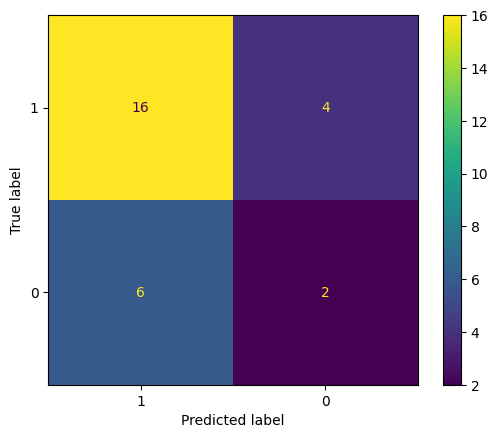

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.75      0.75      0.75        20
           0       0.29      0.29      0.29         7

    accuracy                           0.63        27
   macro avg       0.52      0.52      0.52        27
weighted avg       0.63      0.63      0.63        27



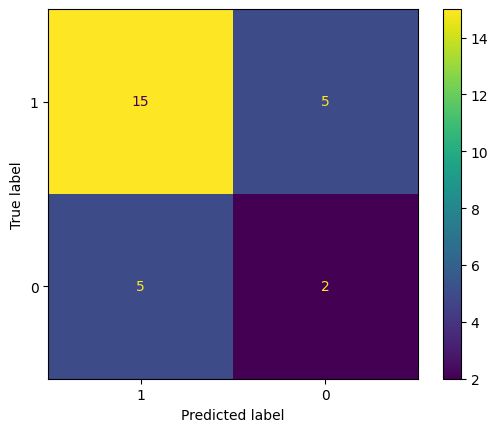

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.70      0.80      0.74        20
           0       0.00      0.00      0.00         7

    accuracy                           0.59        27
   macro avg       0.35      0.40      0.37        27
weighted avg       0.52      0.59      0.55        27



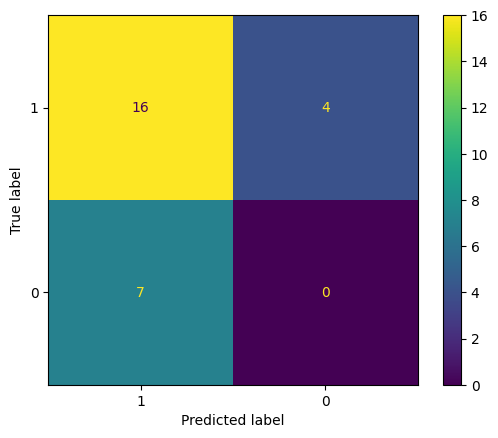

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.74      1.00      0.85        20
           0       0.00      0.00      0.00         7

    accuracy                           0.74        27
   macro avg       0.37      0.50      0.43        27
weighted avg       0.55      0.74      0.63        27



/home/edge/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edge/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edge/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


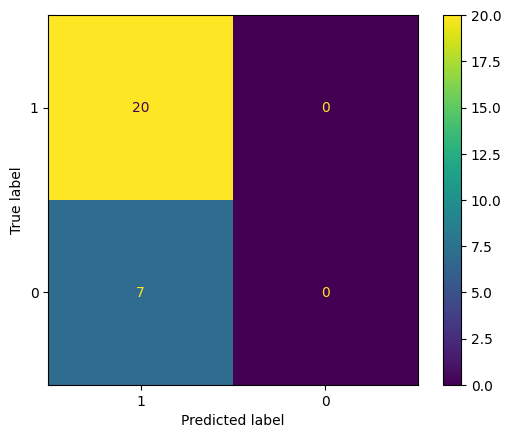

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.75      0.90      0.82        20
           0       0.33      0.14      0.20         7

    accuracy                           0.70        27
   macro avg       0.54      0.52      0.51        27
weighted avg       0.64      0.70      0.66        27



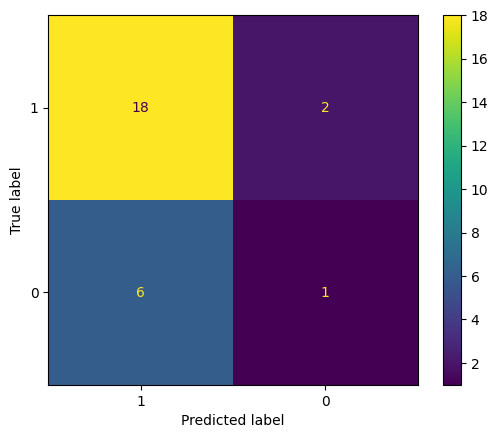

Accuracy in train:
Maximum Accuracy in train: 0.8256880733944955
Minimum Accuracy in train: 0.7798165137614679
Mean Accuracy in train: 0.7977743798844716
Accuracy in test:
Maximum Accuracy in test: 0.7407407407407407
Minimum Accuracy in test: 0.5925925925925926
Mean Accuracy in test: 0.6619047619047619
Overall TEST Confusion matrix:



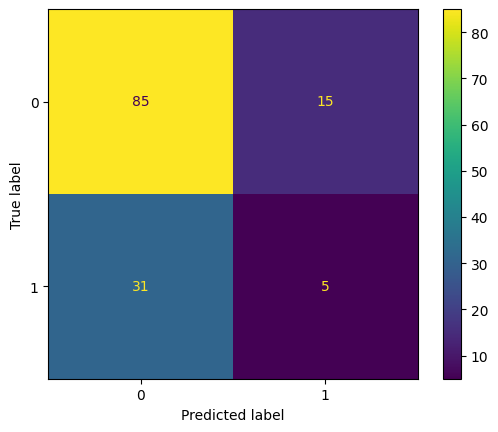

In [268]:
# classification filter 24 hours:
train(df_oasis_24)

        0
0    39.0
1    38.0
2    39.0
3    36.0
4    51.0
..    ...
131  35.0
132  48.0
133  47.0
134  51.0
135  51.0

[136 rows x 1 columns]
              precision    recall  f1-score   support

           1       0.68      0.75      0.71        20
           0       0.17      0.12      0.14         8

    accuracy                           0.57        28
   macro avg       0.42      0.44      0.43        28
weighted avg       0.53      0.57      0.55        28



/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


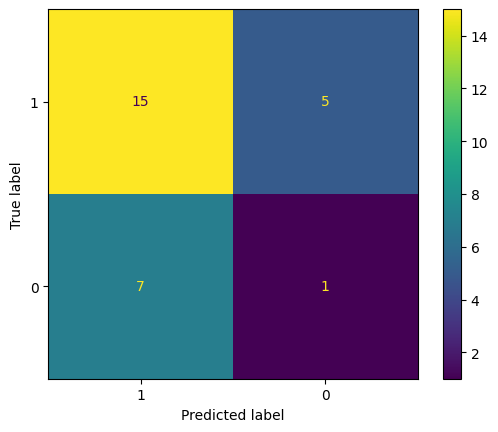

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.71      0.75      0.73        20
           0       0.17      0.14      0.15         7

    accuracy                           0.59        27
   macro avg       0.44      0.45      0.44        27
weighted avg       0.57      0.59      0.58        27



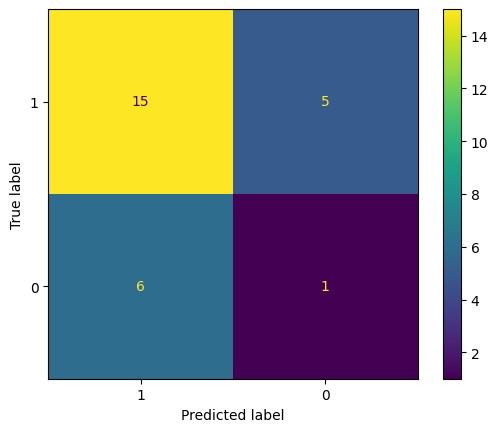

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.77      0.85      0.81        20
           0       0.40      0.29      0.33         7

    accuracy                           0.70        27
   macro avg       0.59      0.57      0.57        27
weighted avg       0.68      0.70      0.69        27



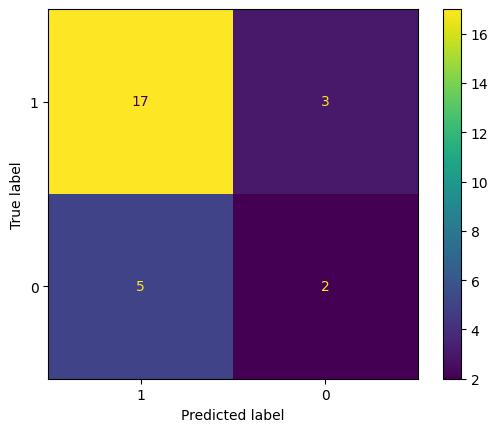

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.75      0.90      0.82        20
           0       0.33      0.14      0.20         7

    accuracy                           0.70        27
   macro avg       0.54      0.52      0.51        27
weighted avg       0.64      0.70      0.66        27



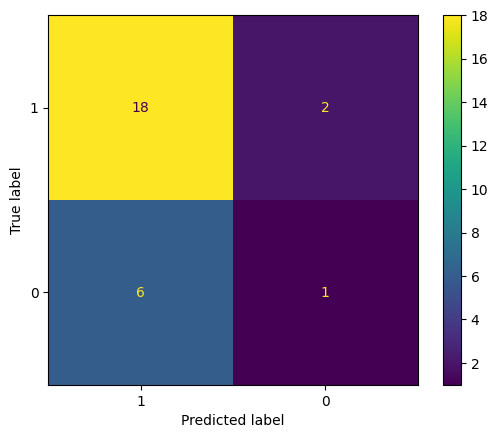

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.82      0.90      0.86        20
           0       0.60      0.43      0.50         7

    accuracy                           0.78        27
   macro avg       0.71      0.66      0.68        27
weighted avg       0.76      0.78      0.76        27



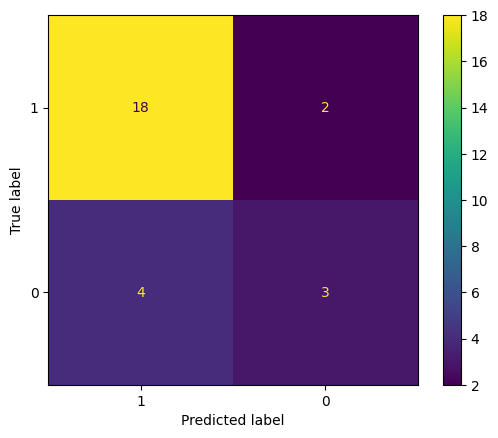

Accuracy in train:
Maximum Accuracy in train: 0.8148148148148148
Minimum Accuracy in train: 0.7889908256880734
Mean Accuracy in train: 0.8014950730547061
Accuracy in test:
Maximum Accuracy in test: 0.7777777777777778
Minimum Accuracy in test: 0.5714285714285714
Mean Accuracy in test: 0.6698412698412698
Overall TEST Confusion matrix:



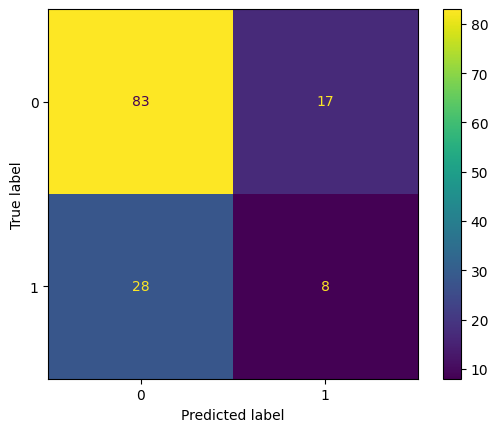

In [269]:
# classification filter 48 hours:
train(df_oasis_48)

       0
0   39.0
1   51.0
2   52.0
3   35.0
4   19.0
5   54.0
6   43.0
7   40.0
8   25.0
9   25.0
10  37.0
11  46.0
12  52.0
13  38.0
14  49.0
15  47.0
16  57.0
17  34.0
18  55.0
19  31.0
20  51.0
21  24.0
22  46.0
23  41.0
24  44.0
25  36.0
26  46.0
27  41.0
28  33.0
29  35.0
30  17.0
31  50.0
32  58.0
33  40.0
34  44.0
35  49.0
36  52.0
37  36.0
38  46.0
39  52.0
40  53.0
41  47.0
42  51.0
43  52.0
44  56.0
45  40.0
46  33.0
47  42.0
48  35.0
49  38.0
50  35.0
51  48.0
52  47.0
53  51.0
              precision    recall  f1-score   support

           1       0.62      0.71      0.67         7
           0       0.33      0.25      0.29         4

    accuracy                           0.55        11
   macro avg       0.48      0.48      0.48        11
weighted avg       0.52      0.55      0.53        11



/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


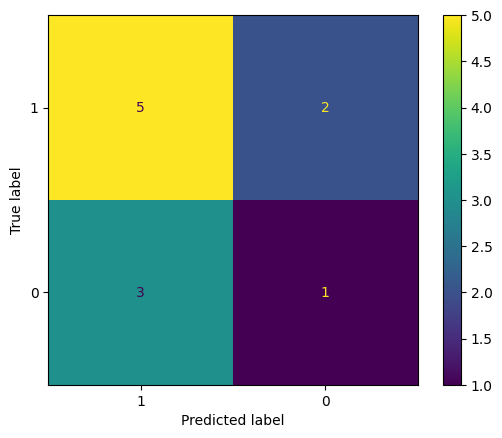

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.67      0.33      0.44         6
           0       0.50      0.80      0.62         5

    accuracy                           0.55        11
   macro avg       0.58      0.57      0.53        11
weighted avg       0.59      0.55      0.52        11



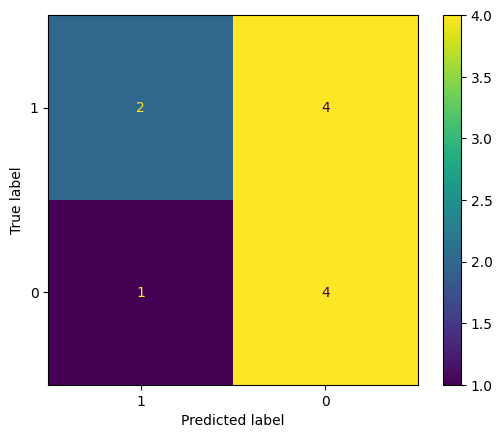

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.62      0.83      0.71         6
           0       0.67      0.40      0.50         5

    accuracy                           0.64        11
   macro avg       0.65      0.62      0.61        11
weighted avg       0.64      0.64      0.62        11



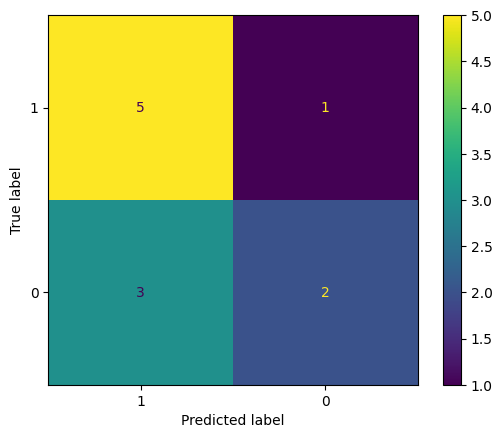

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.43      0.50      0.46         6
           0       0.25      0.20      0.22         5

    accuracy                           0.36        11
   macro avg       0.34      0.35      0.34        11
weighted avg       0.35      0.36      0.35        11



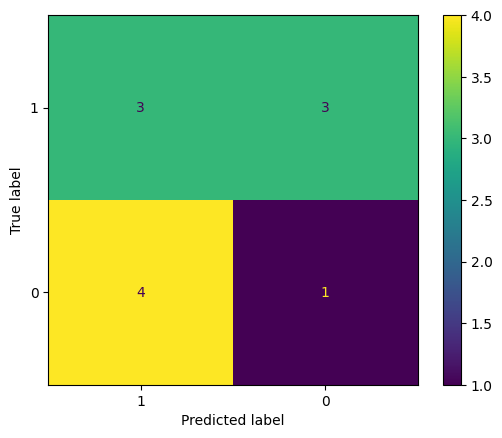

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.62      0.83      0.71         6
           0       0.50      0.25      0.33         4

    accuracy                           0.60        10
   macro avg       0.56      0.54      0.52        10
weighted avg       0.57      0.60      0.56        10



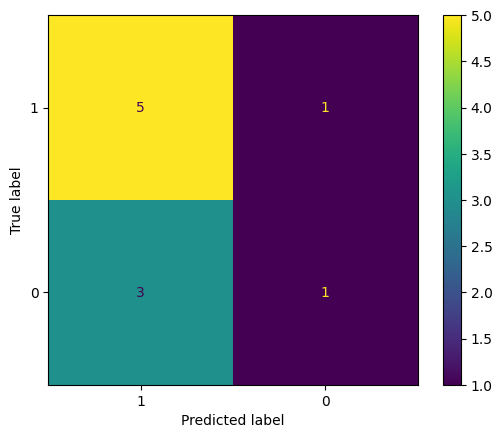

Accuracy in train:
Maximum Accuracy in train: 0.8636363636363636
Minimum Accuracy in train: 0.7906976744186046
Mean Accuracy in train: 0.8285412262156449
Accuracy in test:
Maximum Accuracy in test: 0.6363636363636364
Minimum Accuracy in test: 0.36363636363636365
Mean Accuracy in test: 0.5381818181818182
Overall TEST Confusion matrix:



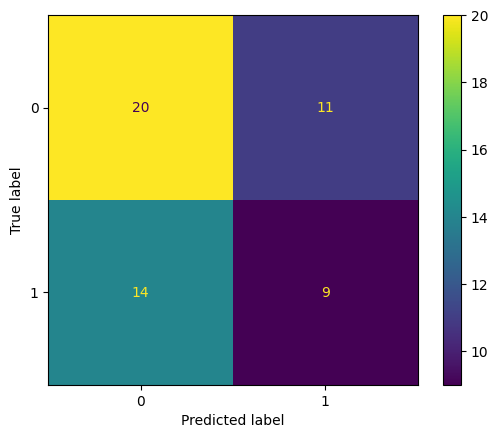

In [270]:
# classification filter 48 not accepting nan hours:
train(df_oasis_48_nan)

In [299]:
# FINAL RESULTS
print('Modified Oasis formula filtering 24h, the mean test accuray is: 66.1%')
print('Modified Oasis formula filtering 48h, the mean test accuray is: 66.9%')
print('Original Oasis formula filtering 48h, the mean test accuray is: 53.8%')

Modified Oasis formula filtering 24h, the mean test accuray is: 66.1%
Modified Oasis formula filtering 48h, the mean test accuray is: 66.9%
Original Oasis formula filtering 48h, the mean test accuray is: 53.8%


## Exercise 2:

1. Compute:
    - the number of different patients in the dataset 
    - the number of different hospital admissions in the dataset 
    - the number of different icu stays in the dataset 
2. Show with an example that we can have a patient with more than one icustay.
3. Revise the number of ICU admissions registered by the two different systems: Metavision and Carevue.
4. Compute the number of NaN OASIS values for your different implementations.
5. Explain the difference between 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table.


### 2.1.1) Number of different patients in the dataset
My age_df dataframe has all patients of the dataset as it comes directly from it. I should select the 'subject_id' column and get the unique entries, in order to know how many different patients are in the dataset

In [ ]:
print('Number of different patients in the dataset is:', len(age_df['subject_id'].unique()))

### 2.1.2) Number of different hospital admissions in the dataset

hadm_id is the id of admissions in the dataset. As age_df is a merged dataset between PATIENTS and ADMISSIONS dataframes i can get the number of unique hospital admissions from that dataset.

In [ ]:
print('Number of different hospital admissions in the dataset is:', len(age_df['hadm_id'].unique()))

### 2.1.3) Number of different ICU stays in the dataset

In [ ]:
print('Number of different ICU stays in the dataset is:', len(age_df['icustay_id'].unique()))

### 2.2) Example of a patient with more than one ICUstay

In [ ]:
repeated_icustays = age_df.groupby('icustay_id').filter(lambda x: len(x) > 1)
repeated_icustays

In [ ]:
print('There are', len(repeated_icustays['subject_id'].unique()), 'patients with more than 1 icustay_id. An example could be patient', repeated_icustays['subject_id'].iloc[0])

### 2.3) Number of ICU admissions registered in Metavision and Carevue

In [ ]:
# reading (again) ICUstays df. As this df has ICU stays as primary key, all entries are unique
df_icustays = pd.read_csv(path+'ICUSTAYS.csv')
print(df_icustays.shape)
df_icustays.head()

In [ ]:
print('Number of ICU admissions registered in MEtavision and Carevue: \n', df_icustays['dbsource'].value_counts())

### 2.4) Number of NaN OASIS values for the different implementations

In [111]:
print('Number of NaN in the 24 hours dataset, allowing NaN:',df_oasis_24['oasis'].isna().sum())
print('Number of NaN in the 48 hours dataset, using the original OASIS:',df_oasis_48_nan['oasis'].isna().sum())
print('Number of NaN in the 48 hours dataset, allowing NaN:',df_oasis_48['oasis'].isna().sum())

Number of NaN in the 24 hours dataset, allowing NaN: 0
Number of NaN in the 48 hours dataset, using the original OASIS: 82
Number of NaN in the 48 hours dataset, allowing NaN: 0


### 2.5) Explain the difference between 'intime' from ICUSTAYS and 'admintime' from ADMISSIONS table

The difference between 'intime' and 'admintime' is that 'intime' is the time admited to the ICU whereas 'adimntime' is the time admited to the hospital. Thus, a patient is only admited 1 time to the hospital but during that stay can be admited to the ICU on several occasions, this is why there are many more entries in ICUSTAYS table than ADMISSIONS table.

## Exercise 3:

Try to improve the prediction of the length of stay (LOS) of the ICU patients using all available variables (instead of the Oasis score) in the classification model learning a multidimensional decision boundary.

### Solution
As the best model has been scores of oasis after filtering for 48h allowing NaNs I will use this dataset for training. The added variables that I will try are: 'admission_type','icustay_id','age','prelos'

In [286]:
# Your solution here:
df_improve = pd.DataFrame()
df_improve = pd.merge(df_oasis_48,age_df[['subject_id', 'hadm_id','admission_type','icustay_id','age','prelos']],on=['icustay_id'])
df_improve

,icustay_id,oasis,los,subject_id,hadm_id,admission_type,age,prelos
0,206504,39.0,0,10006,142345,emergency,70,0.020833
1,232110,38.0,1,10011,105331,emergency,36,0.033333
2,264446,39.0,0,10013,165520,emergency,87,0.033333
3,204881,36.0,0,10017,199207,emergency,74,73.558056
4,228977,51.0,0,10019,177759,emergency,49,0.015556
...,...,...,...,...,...,...,...,...
131,286428,35.0,0,44083,198330,emergency,55,10.275833
132,217724,48.0,0,44154,174245,emergency,95,0.015278
133,239396,47.0,1,44212,163189,emergency,45,0.008056
134,238186,51.0,0,44222,192189,emergency,73,0.027222


In [287]:
# encoding admission type
dummies = pd.get_dummies(df_improve['admission_type'])
df_improve = pd.concat([df_improve, dummies], axis=1)
df_improve = df_improve.drop('admission_type', axis = 1)
df_improve

,icustay_id,oasis,los,subject_id,hadm_id,age,prelos,elective,emergency,urgent
0,206504,39.0,0,10006,142345,70,0.020833,0,1,0
1,232110,38.0,1,10011,105331,36,0.033333,0,1,0
2,264446,39.0,0,10013,165520,87,0.033333,0,1,0
3,204881,36.0,0,10017,199207,74,73.558056,0,1,0
4,228977,51.0,0,10019,177759,49,0.015556,0,1,0
...,...,...,...,...,...,...,...,...,...,...
131,286428,35.0,0,44083,198330,55,10.275833,0,1,0
132,217724,48.0,0,44154,174245,95,0.015278,0,1,0
133,239396,47.0,1,44212,163189,45,0.008056,0,1,0
134,238186,51.0,0,44222,192189,73,0.027222,0,1,0


        0     1          2    3    4    5
0    39.0  70.0   0.020833  0.0  1.0  0.0
1    38.0  36.0   0.033333  0.0  1.0  0.0
2    39.0  87.0   0.033333  0.0  1.0  0.0
3    36.0  74.0  73.558056  0.0  1.0  0.0
4    51.0  49.0   0.015556  0.0  1.0  0.0
..    ...   ...        ...  ...  ...  ...
131  35.0  55.0  10.275833  0.0  1.0  0.0
132  48.0  95.0   0.015278  0.0  1.0  0.0
133  47.0  45.0   0.008056  0.0  1.0  0.0
134  51.0  73.0   0.027222  0.0  1.0  0.0
135  51.0  58.0   1.460833  0.0  1.0  0.0

[136 rows x 6 columns]
              precision    recall  f1-score   support

           1       0.70      0.80      0.74        20
           0       0.20      0.12      0.15         8

    accuracy                           0.61        28
   macro avg       0.45      0.46      0.45        28
weighted avg       0.55      0.61      0.58        28



/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


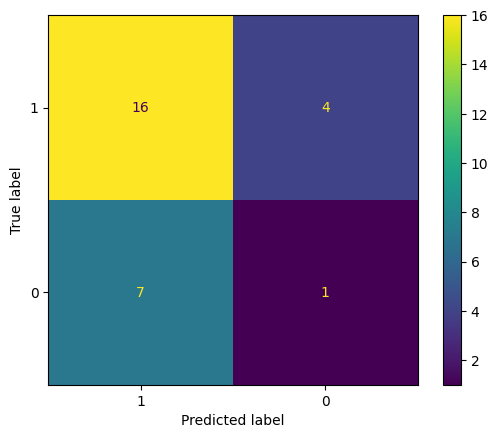

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.75      0.90      0.82        20
           0       0.33      0.14      0.20         7

    accuracy                           0.70        27
   macro avg       0.54      0.52      0.51        27
weighted avg       0.64      0.70      0.66        27



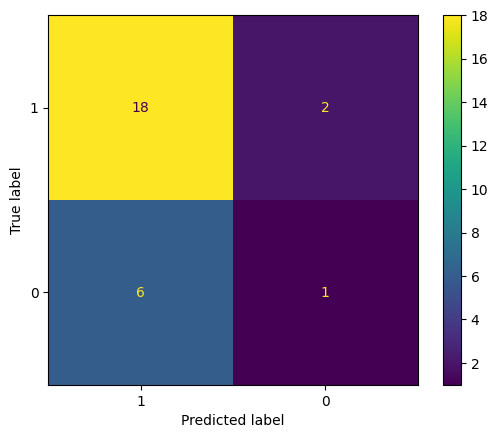

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.78      0.90      0.84        20
           0       0.50      0.29      0.36         7

    accuracy                           0.74        27
   macro avg       0.64      0.59      0.60        27
weighted avg       0.71      0.74      0.71        27



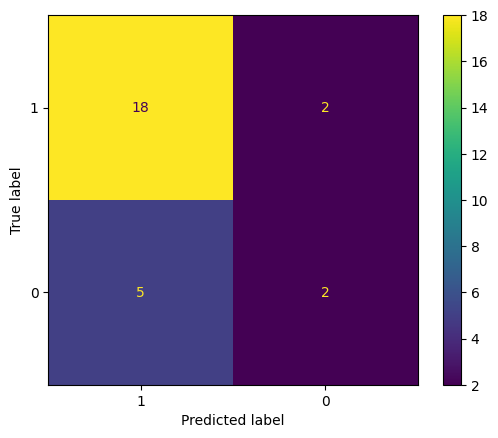

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.79      0.95      0.86        20
           0       0.67      0.29      0.40         7

    accuracy                           0.78        27
   macro avg       0.73      0.62      0.63        27
weighted avg       0.76      0.78      0.74        27



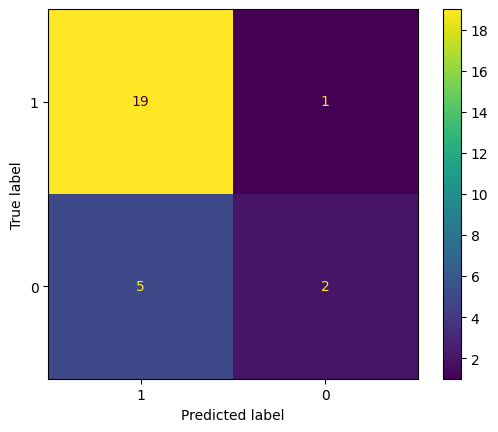

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.74      0.85      0.79        20
           0       0.25      0.14      0.18         7

    accuracy                           0.67        27
   macro avg       0.49      0.50      0.49        27
weighted avg       0.61      0.67      0.63        27



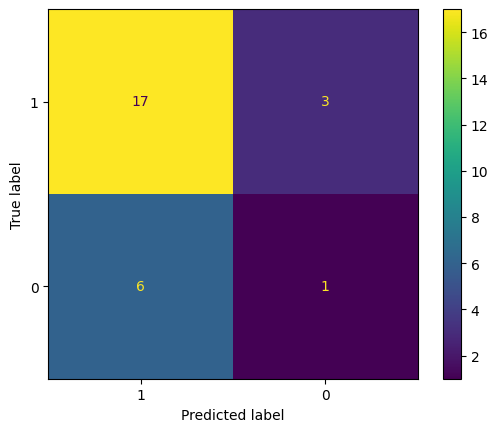

Accuracy in train:
Maximum Accuracy in train: 1.0
Minimum Accuracy in train: 1.0
Mean Accuracy in train: 1.0
Accuracy in test:
Maximum Accuracy in test: 0.7777777777777778
Minimum Accuracy in test: 0.6071428571428571
Mean Accuracy in test: 0.6992063492063492
Overall TEST Confusion matrix:



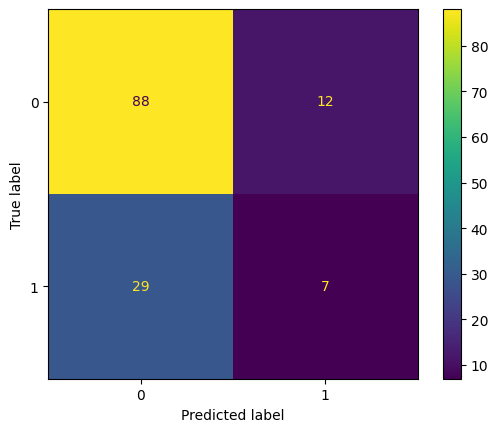

In [288]:
train(df_improve)

We get a 3% improvement, but we could try to add more data.

In [289]:
# selecting minimum GCS
df_48_GCS_min = df_48_GCS.groupby(['subject_id', 'hadm_id', 'icustay_id']).min().reset_index()

In [290]:
df_improve = pd.merge(df_improve, df_48_GCS_min, on = ['subject_id', 'hadm_id', 'icustay_id'], how='left')
df_improve

,icustay_id,oasis,los,subject_id,hadm_id,age,prelos,elective,emergency,urgent,GCS_total
0,206504,39.0,0,10006,142345,70,0.020833,0,1,0,15.0
1,232110,38.0,1,10011,105331,36,0.033333,0,1,0,4.0
2,264446,39.0,0,10013,165520,87,0.033333,0,1,0,8.0
3,204881,36.0,0,10017,199207,74,73.558056,0,1,0,14.0
4,228977,51.0,0,10019,177759,49,0.015556,0,1,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
131,286428,35.0,0,44083,198330,55,10.275833,0,1,0,4.0
132,217724,48.0,0,44154,174245,95,0.015278,0,1,0,1.0
133,239396,47.0,1,44212,163189,45,0.008056,0,1,0,1.0
134,238186,51.0,0,44222,192189,73,0.027222,0,1,0,4.0


        0     1          2    3    4    5     6
0    39.0  70.0   0.020833  0.0  1.0  0.0  15.0
1    38.0  36.0   0.033333  0.0  1.0  0.0   4.0
2    39.0  87.0   0.033333  0.0  1.0  0.0   8.0
3    36.0  74.0  73.558056  0.0  1.0  0.0  14.0
4    51.0  49.0   0.015556  0.0  1.0  0.0   3.0
..    ...   ...        ...  ...  ...  ...   ...
127  35.0  55.0  10.275833  0.0  1.0  0.0   4.0
128  48.0  95.0   0.015278  0.0  1.0  0.0   1.0
129  47.0  45.0   0.008056  0.0  1.0  0.0   1.0
130  51.0  73.0   0.027222  0.0  1.0  0.0   4.0
131  51.0  58.0   1.460833  0.0  1.0  0.0   3.0

[132 rows x 7 columns]
              precision    recall  f1-score   support

           1       0.81      0.85      0.83        20
           0       0.50      0.43      0.46         7

    accuracy                           0.74        27
   macro avg       0.65      0.64      0.65        27
weighted avg       0.73      0.74      0.73        27



/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


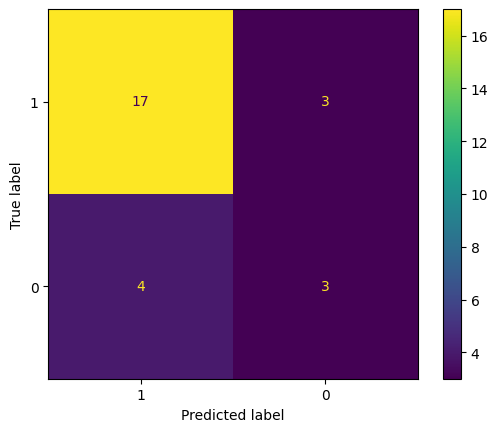

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.73      0.84      0.78        19
           0       0.40      0.25      0.31         8

    accuracy                           0.67        27
   macro avg       0.56      0.55      0.54        27
weighted avg       0.63      0.67      0.64        27



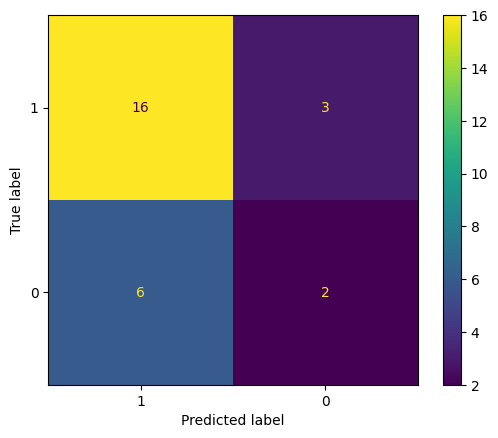

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.86      0.95      0.90        19
           0       0.80      0.57      0.67         7

    accuracy                           0.85        26
   macro avg       0.83      0.76      0.78        26
weighted avg       0.84      0.85      0.84        26



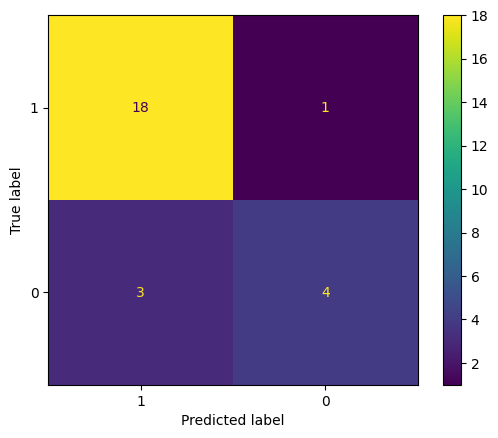

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.74      0.89      0.81        19
           0       0.33      0.14      0.20         7

    accuracy                           0.69        26
   macro avg       0.54      0.52      0.50        26
weighted avg       0.63      0.69      0.65        26



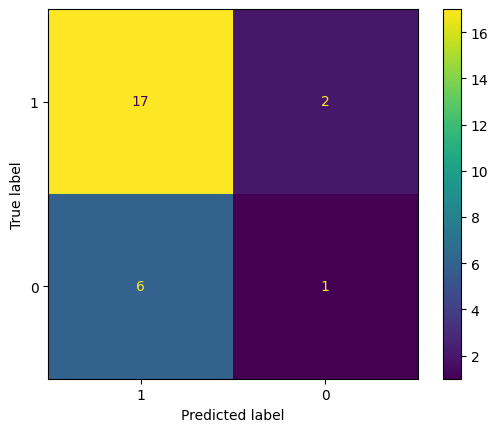

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.75      0.95      0.84        19
           0       0.50      0.14      0.22         7

    accuracy                           0.73        26
   macro avg       0.62      0.55      0.53        26
weighted avg       0.68      0.73      0.67        26



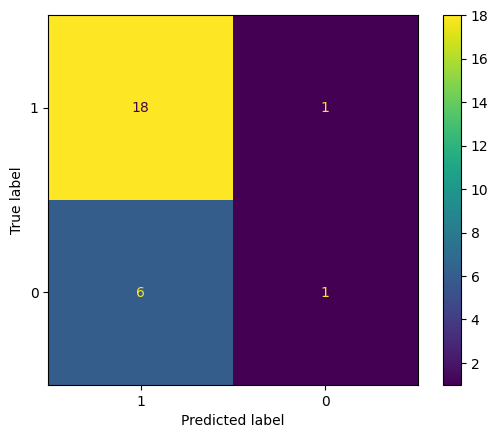

Accuracy in train:
Maximum Accuracy in train: 1.0
Minimum Accuracy in train: 1.0
Mean Accuracy in train: 1.0
Accuracy in test:
Maximum Accuracy in test: 0.8461538461538461
Minimum Accuracy in test: 0.6666666666666666
Mean Accuracy in test: 0.7353276353276353
Overall TEST Confusion matrix:



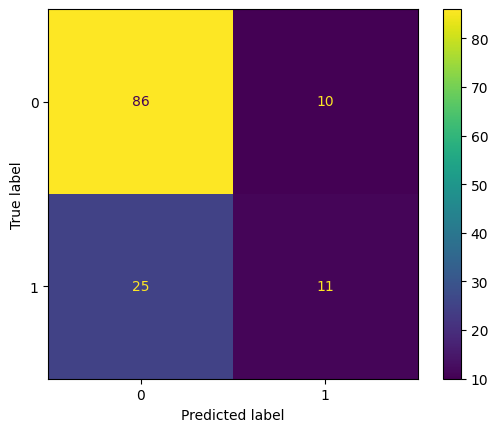

In [291]:
train(df_improve)

Adding the minimum values of GCS we have had a mean accuracy improvement of 6% with respect to the oasis only model. Let's try without Oasis score now. 

        0          1    2    3    4     5
0    70.0   0.020833  0.0  1.0  0.0  15.0
1    36.0   0.033333  0.0  1.0  0.0   4.0
2    87.0   0.033333  0.0  1.0  0.0   8.0
3    74.0  73.558056  0.0  1.0  0.0  14.0
4    49.0   0.015556  0.0  1.0  0.0   3.0
..    ...        ...  ...  ...  ...   ...
127  55.0  10.275833  0.0  1.0  0.0   4.0
128  95.0   0.015278  0.0  1.0  0.0   1.0
129  45.0   0.008056  0.0  1.0  0.0   1.0
130  73.0   0.027222  0.0  1.0  0.0   4.0
131  58.0   1.460833  0.0  1.0  0.0   3.0

[132 rows x 6 columns]
              precision    recall  f1-score   support

           1       0.81      0.85      0.83        20
           0       0.50      0.43      0.46         7

    accuracy                           0.74        27
   macro avg       0.65      0.64      0.65        27
weighted avg       0.73      0.74      0.73        27



/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


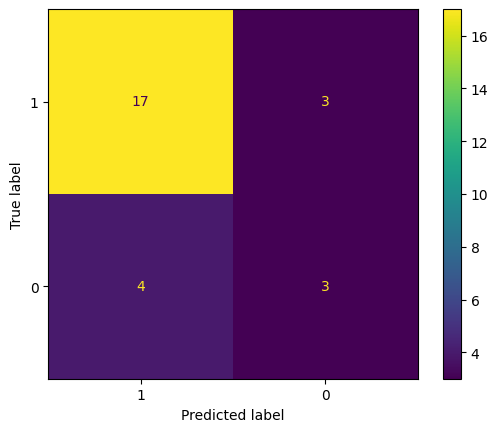

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.70      0.74      0.72        19
           0       0.29      0.25      0.27         8

    accuracy                           0.59        27
   macro avg       0.49      0.49      0.49        27
weighted avg       0.58      0.59      0.58        27



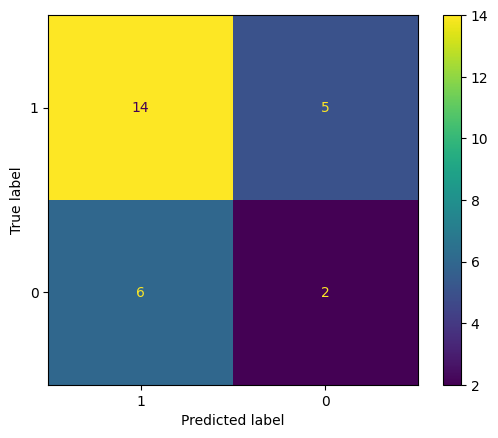

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.78      0.95      0.86        19
           0       0.67      0.29      0.40         7

    accuracy                           0.77        26
   macro avg       0.72      0.62      0.63        26
weighted avg       0.75      0.77      0.73        26



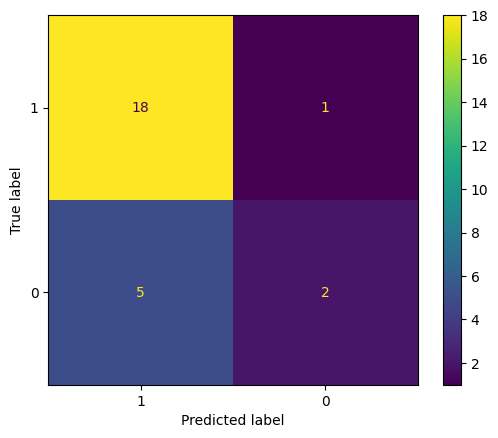

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.78      0.95      0.86        19
           0       0.67      0.29      0.40         7

    accuracy                           0.77        26
   macro avg       0.72      0.62      0.63        26
weighted avg       0.75      0.77      0.73        26



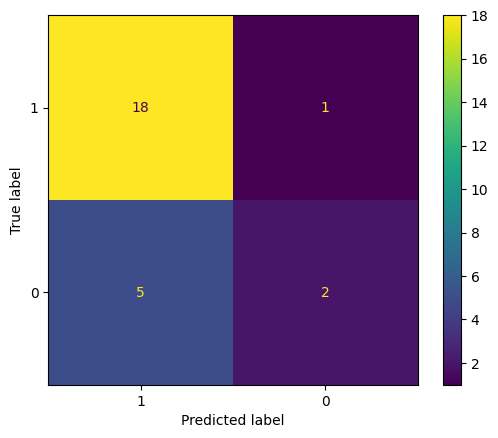

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.71      0.89      0.79        19
           0       0.00      0.00      0.00         7

    accuracy                           0.65        26
   macro avg       0.35      0.45      0.40        26
weighted avg       0.52      0.65      0.58        26



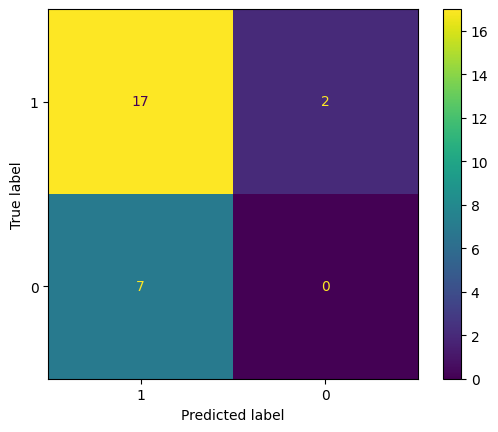

Accuracy in train:
Maximum Accuracy in train: 1.0
Minimum Accuracy in train: 1.0
Mean Accuracy in train: 1.0
Accuracy in test:
Maximum Accuracy in test: 0.7692307692307693
Minimum Accuracy in test: 0.5925925925925926
Mean Accuracy in test: 0.7051282051282052
Overall TEST Confusion matrix:



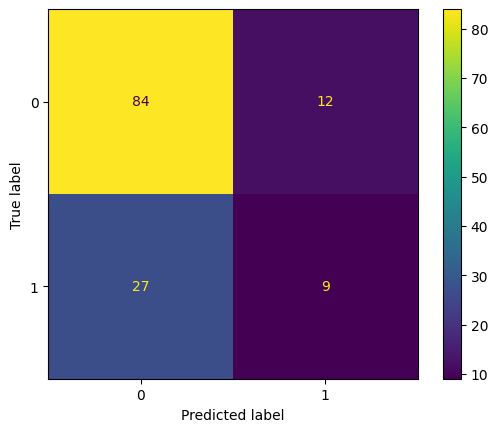

In [292]:
train(pd.DataFrame(df_improve.drop('oasis', axis=1)))

We can see that Oasis is an important feature as the model has reduced the mean test accuracy by 2%. Now we can try to add ventilation feature as binary (1 for y and 0 for n).

In [293]:
df_ventilation['ventilated'] = df_ventilation['ventilated'].replace({'y': 1, 'n': 0})
df_improve = pd.merge(df_improve, df_ventilation, on = ['subject_id', 'hadm_id', 'icustay_id'], how='left')
df_improve

,icustay_id,oasis,los,subject_id,hadm_id,age,prelos,elective,emergency,urgent,GCS_total,ventilated
0,206504,39.0,0,10006,142345,70,0.020833,0,1,0,15.0,0
1,232110,38.0,1,10011,105331,36,0.033333,0,1,0,4.0,0
2,264446,39.0,0,10013,165520,87,0.033333,0,1,0,8.0,0
3,204881,36.0,0,10017,199207,74,73.558056,0,1,0,14.0,0
4,228977,51.0,0,10019,177759,49,0.015556,0,1,0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
131,286428,35.0,0,44083,198330,55,10.275833,0,1,0,4.0,0
132,217724,48.0,0,44154,174245,95,0.015278,0,1,0,1.0,1
133,239396,47.0,1,44212,163189,45,0.008056,0,1,0,1.0,1
134,238186,51.0,0,44222,192189,73,0.027222,0,1,0,4.0,0


        0     1          2    3    4    5     6    7
0    39.0  70.0   0.020833  0.0  1.0  0.0  15.0  0.0
1    38.0  36.0   0.033333  0.0  1.0  0.0   4.0  0.0
2    39.0  87.0   0.033333  0.0  1.0  0.0   8.0  0.0
3    36.0  74.0  73.558056  0.0  1.0  0.0  14.0  0.0
4    51.0  49.0   0.015556  0.0  1.0  0.0   3.0  0.0
..    ...   ...        ...  ...  ...  ...   ...  ...
127  35.0  55.0  10.275833  0.0  1.0  0.0   4.0  0.0
128  48.0  95.0   0.015278  0.0  1.0  0.0   1.0  1.0
129  47.0  45.0   0.008056  0.0  1.0  0.0   1.0  1.0
130  51.0  73.0   0.027222  0.0  1.0  0.0   4.0  0.0
131  51.0  58.0   1.460833  0.0  1.0  0.0   3.0  0.0

[132 rows x 8 columns]
              precision    recall  f1-score   support

           1       0.78      0.90      0.84        20
           0       0.50      0.29      0.36         7

    accuracy                           0.74        27
   macro avg       0.64      0.59      0.60        27
weighted avg       0.71      0.74      0.71        27



/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


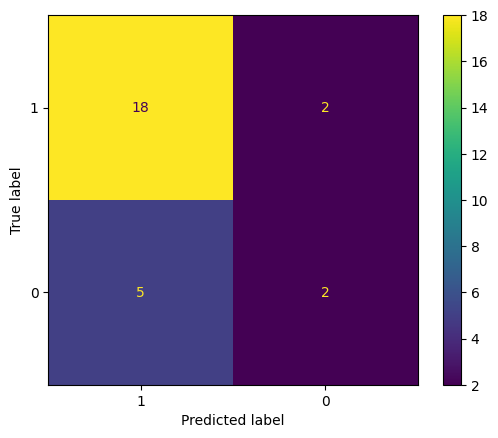

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.74      0.89      0.81        19
           0       0.50      0.25      0.33         8

    accuracy                           0.70        27
   macro avg       0.62      0.57      0.57        27
weighted avg       0.67      0.70      0.67        27



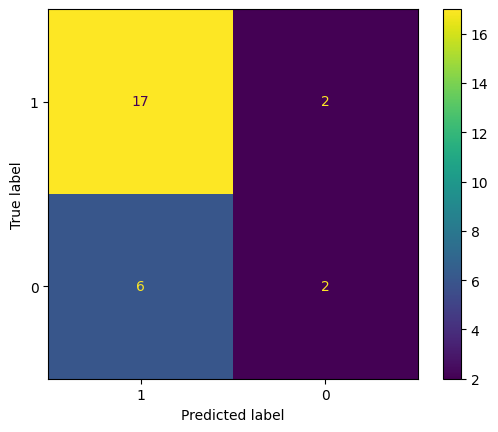

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.81      0.89      0.85        19
           0       0.60      0.43      0.50         7

    accuracy                           0.77        26
   macro avg       0.70      0.66      0.68        26
weighted avg       0.75      0.77      0.76        26



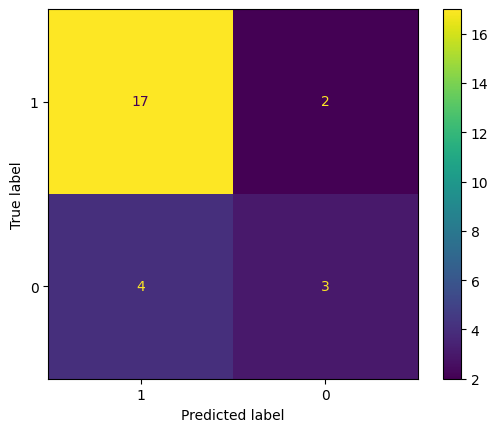

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.74      0.89      0.81        19
           0       0.33      0.14      0.20         7

    accuracy                           0.69        26
   macro avg       0.54      0.52      0.50        26
weighted avg       0.63      0.69      0.65        26



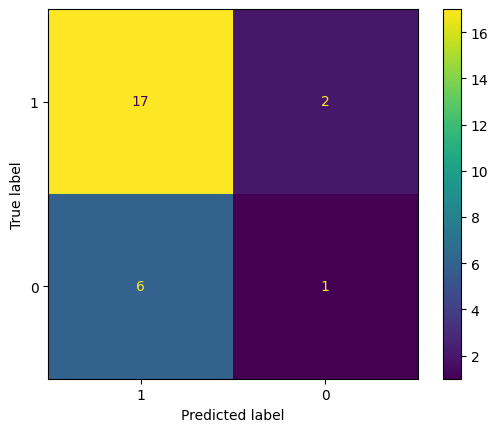

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.74      0.89      0.81        19
           0       0.33      0.14      0.20         7

    accuracy                           0.69        26
   macro avg       0.54      0.52      0.50        26
weighted avg       0.63      0.69      0.65        26



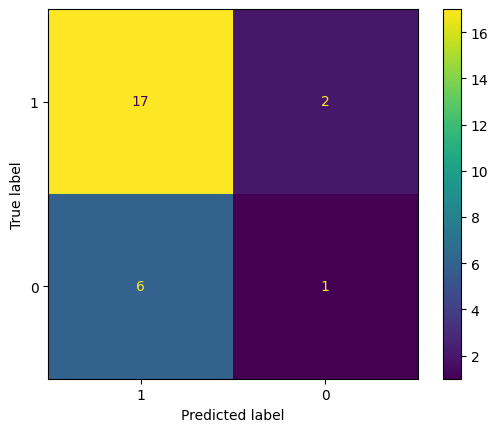

Accuracy in train:
Maximum Accuracy in train: 1.0
Minimum Accuracy in train: 1.0
Mean Accuracy in train: 1.0
Accuracy in test:
Maximum Accuracy in test: 0.7692307692307693
Minimum Accuracy in test: 0.6923076923076923
Mean Accuracy in test: 0.7196581196581197
Overall TEST Confusion matrix:



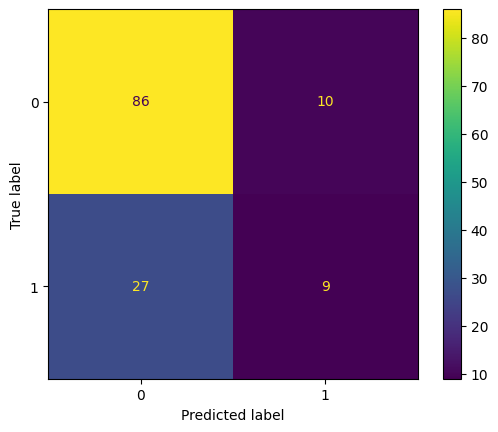

In [294]:
train(df_improve)

There isn't a big difference in performance when adding Ventilation information. Let's try with urine which is the only variable left with a reasonable amount of non repeated obervations.

In [295]:
df_48_urine.shape

(136, 4)

In [296]:
df_improve = pd.merge(df_improve, df_48_urine, on = ['subject_id', 'hadm_id', 'icustay_id'], how='left')
df_improve

,icustay_id,oasis,los,subject_id,hadm_id,age,prelos,elective,emergency,urgent,GCS_total,ventilated,urine
0,206504,39.0,0,10006,142345,70,0.020833,0,1,0,15.0,0,200.0
1,232110,38.0,1,10011,105331,36,0.033333,0,1,0,4.0,0,61000.0
2,264446,39.0,0,10013,165520,87,0.033333,0,1,0,8.0,0,3150.0
3,204881,36.0,0,10017,199207,74,73.558056,0,1,0,14.0,0,10580.0
4,228977,51.0,0,10019,177759,49,0.015556,0,1,0,3.0,0,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,286428,35.0,0,44083,198330,55,10.275833,0,1,0,4.0,0,5420.0
132,217724,48.0,0,44154,174245,95,0.015278,0,1,0,1.0,1,1280.0
133,239396,47.0,1,44212,163189,45,0.008056,0,1,0,1.0,1,1378.0
134,238186,51.0,0,44222,192189,73,0.027222,0,1,0,4.0,0,0.0


        0     1          2    3    4    5     6    7        8
0    39.0  70.0   0.020833  0.0  1.0  0.0  15.0  0.0    200.0
1    38.0  36.0   0.033333  0.0  1.0  0.0   4.0  0.0  61000.0
2    39.0  87.0   0.033333  0.0  1.0  0.0   8.0  0.0   3150.0
3    36.0  74.0  73.558056  0.0  1.0  0.0  14.0  0.0  10580.0
4    51.0  49.0   0.015556  0.0  1.0  0.0   3.0  0.0    150.0
..    ...   ...        ...  ...  ...  ...   ...  ...      ...
127  35.0  55.0  10.275833  0.0  1.0  0.0   4.0  0.0   5420.0
128  48.0  95.0   0.015278  0.0  1.0  0.0   1.0  1.0   1280.0
129  47.0  45.0   0.008056  0.0  1.0  0.0   1.0  1.0   1378.0
130  51.0  73.0   0.027222  0.0  1.0  0.0   4.0  0.0      0.0
131  51.0  58.0   1.460833  0.0  1.0  0.0   3.0  0.0  22482.0

[132 rows x 9 columns]
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        20
           0       1.00      0.71      0.83         7

    accuracy                           0.93        27
   macro avg  

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


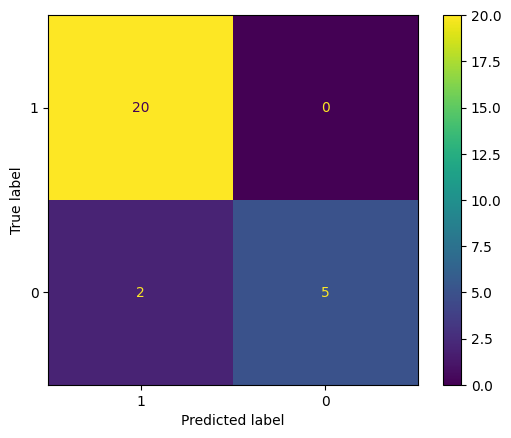

              precision    recall  f1-score   support

           1       0.90      1.00      0.95        19
           0       1.00      0.75      0.86         8

    accuracy                           0.93        27
   macro avg       0.95      0.88      0.90        27
weighted avg       0.93      0.93      0.92        27



/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


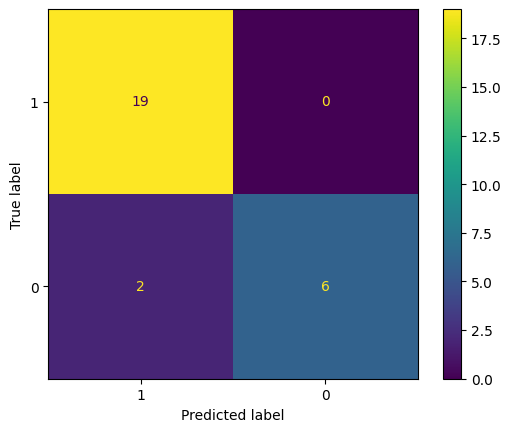

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.86      1.00      0.93        19
           0       1.00      0.57      0.73         7

    accuracy                           0.88        26
   macro avg       0.93      0.79      0.83        26
weighted avg       0.90      0.88      0.87        26



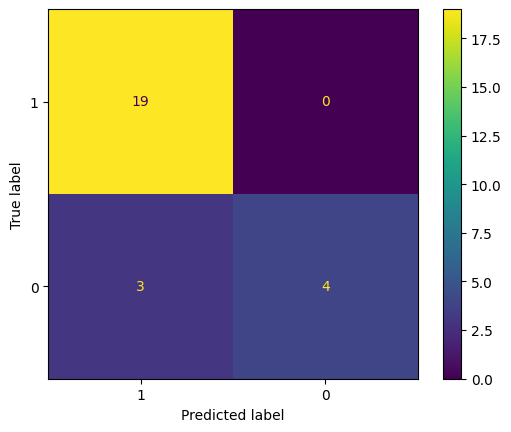

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        19
           0       1.00      1.00      1.00         7

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



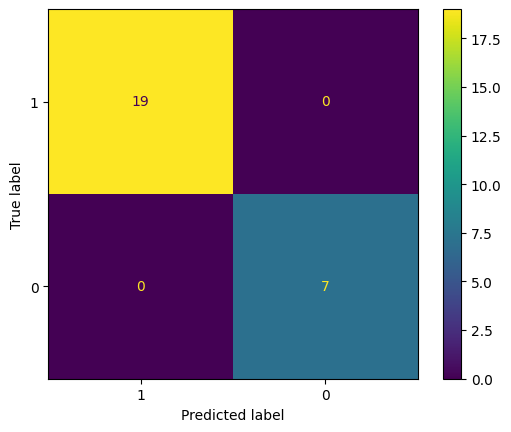

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.86      1.00      0.93        19
           0       1.00      0.57      0.73         7

    accuracy                           0.88        26
   macro avg       0.93      0.79      0.83        26
weighted avg       0.90      0.88      0.87        26



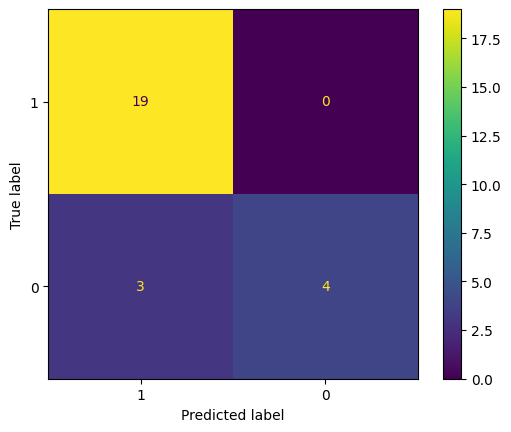

Accuracy in train:
Maximum Accuracy in train: 1.0
Minimum Accuracy in train: 1.0
Mean Accuracy in train: 1.0
Accuracy in test:
Maximum Accuracy in test: 1.0
Minimum Accuracy in test: 0.8846153846153846
Mean Accuracy in test: 0.9242165242165242
Overall TEST Confusion matrix:



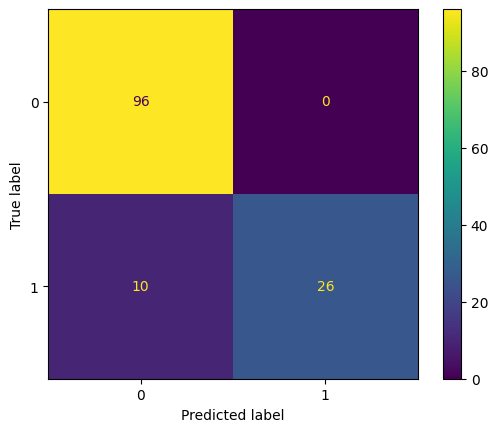

In [297]:
train(df_improve)

We can observe that there is a big change in performance adding urine but it seems as if the model could be overfitting, or only learning from this last added feature as the training is 100% accurate. Let's check if adding only urine the model has the same performance:

In [281]:
df_improve_urine = pd.merge(df_oasis_48, df_48_urine, on = ['icustay_id'], how='left')
df_improve_urine

,icustay_id,oasis,los,subject_id,hadm_id,urine
0,206504,39.0,0,10006,142345,200.0
1,232110,38.0,1,10011,105331,61000.0
2,264446,39.0,0,10013,165520,3150.0
3,204881,36.0,0,10017,199207,10580.0
4,228977,51.0,0,10019,177759,150.0
...,...,...,...,...,...,...
131,286428,35.0,0,44083,198330,5420.0
132,217724,48.0,0,44154,174245,1280.0
133,239396,47.0,1,44212,163189,1378.0
134,238186,51.0,0,44222,192189,0.0


        0        1
0    39.0    200.0
1    38.0  61000.0
2    39.0   3150.0
3    36.0  10580.0
4    51.0    150.0
..    ...      ...
131  35.0   5420.0
132  48.0   1280.0
133  47.0   1378.0
134  51.0      0.0
135  51.0  22482.0

[136 rows x 2 columns]
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        20
           0       1.00      0.75      0.86         8

    accuracy                           0.93        28
   macro avg       0.95      0.88      0.90        28
weighted avg       0.94      0.93      0.93        28



/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


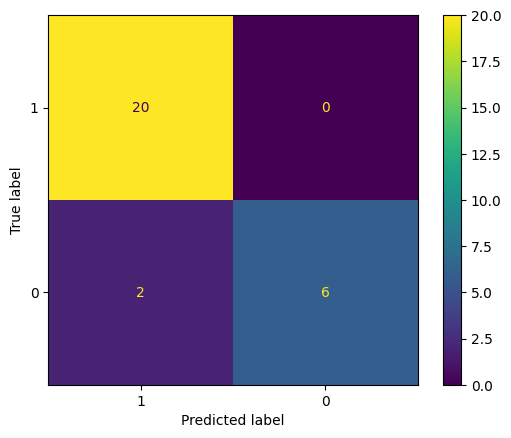

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.91      1.00      0.95        20
           0       1.00      0.71      0.83         7

    accuracy                           0.93        27
   macro avg       0.95      0.86      0.89        27
weighted avg       0.93      0.93      0.92        27



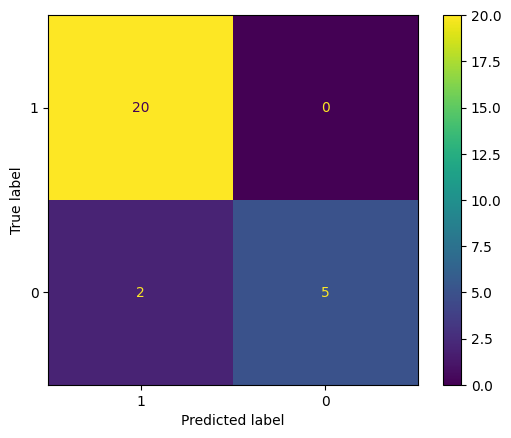

              precision    recall  f1-score   support

           1       0.90      0.95      0.93        20
           0       0.83      0.71      0.77         7

    accuracy                           0.89        27
   macro avg       0.87      0.83      0.85        27
weighted avg       0.89      0.89      0.89        27



/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


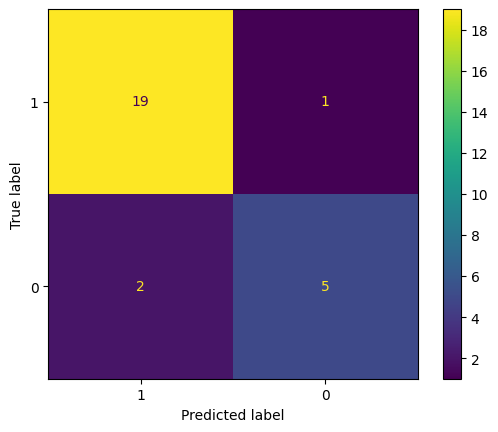

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.90      0.95      0.93        20
           0       0.83      0.71      0.77         7

    accuracy                           0.89        27
   macro avg       0.87      0.83      0.85        27
weighted avg       0.89      0.89      0.89        27



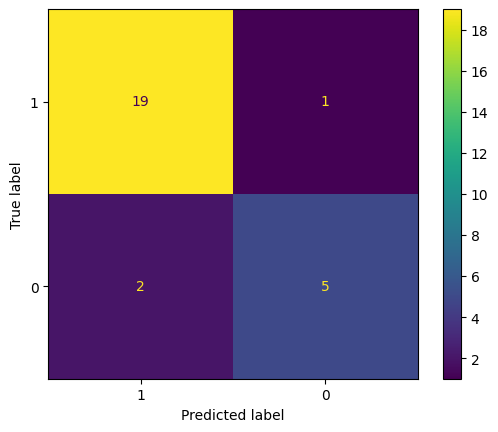

/tmp/ipykernel_102309/2019362146.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)


              precision    recall  f1-score   support

           1       0.95      1.00      0.98        20
           0       1.00      0.86      0.92         7

    accuracy                           0.96        27
   macro avg       0.98      0.93      0.95        27
weighted avg       0.96      0.96      0.96        27



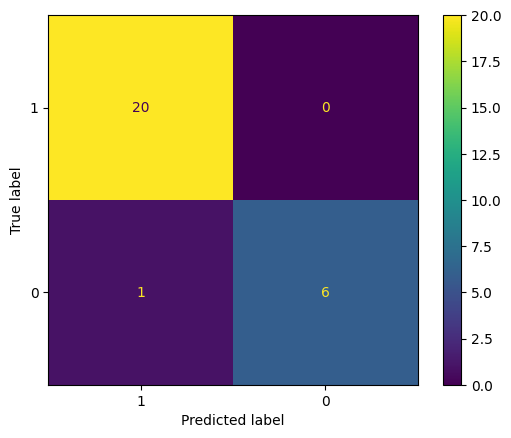

Accuracy in train:
Maximum Accuracy in train: 1.0
Minimum Accuracy in train: 1.0
Mean Accuracy in train: 1.0
Accuracy in test:
Maximum Accuracy in test: 0.9629629629629629
Minimum Accuracy in test: 0.8888888888888888
Mean Accuracy in test: 0.919047619047619
Overall TEST Confusion matrix:



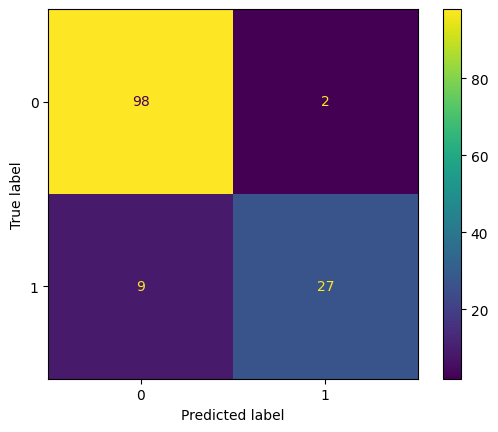

In [282]:
train(df_improve_urine) # training only with urine and Oasis

As we have checked the model trained  only with oasis and urine features has mean accuracy of 91% when testing, I would not consider this as an explainable feature for 2 reasons: urine is already implicit in OASIS score so it could be that we are giving repeated information. Secondly, the goal of the exercise is to add as many variable as possible in order to improve the model, and in this case urine feature does all the work.

Looking into the rest of the variables (heart rate, respiratory rate, MAP and temperature) is harder to compute as they have many entries for each icu_stay, this would mean a lot of increase in our dataframe in terms of samples. It could be a good thing, as we are trining with a very small set but also means that the values of the other already checked features (age, preloss, GCS, type of admission, ...) would have much more weight as they would have  repeated entries. Taking into account that these extra variables are already explained in the set thanks to the OASIS score, I think that the most interesting thing is to stop adding features and conclude that adding age, pre-loss, minimum GCS and type of admission (one-hot-encoded) helps the problem improve in terms of accuray in test by ~6% (from ~66% to ~72%). It is also worth mentioning that training score has improved a lot more (100%) since the start of the addition of features, which it could be an indication of a little bit of overfitting.